<a href="https://colab.research.google.com/github/RyosukeHanaoka/jcr2025/blob/main/swin_transformer_20241129.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install vit_pytorch timm
from __future__ import print_function

import glob
import os
import random
import cv2
import shutil
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
from pathlib import Path
import seaborn as sns
import timm
from pprint import pprint
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from torch.optim import AdamW
from torchvision import transforms

def split_and_move_files(src_dir, train_dest, val_dest, test_dest, split_ratio=(0.6, 0.3, 0.1)):
    all_files = glob.glob(f"{src_dir}/*")
    random.shuffle(all_files)

    train_split = int(split_ratio[0] * len(all_files))
    val_split = train_split + int(split_ratio[1] * len(all_files))

    for idx, file in enumerate(all_files):
        if idx < train_split:
            dest = train_dest
        elif idx < val_split:
            dest = val_dest
        else:
            dest = test_dest
        os.makedirs(dest, exist_ok=True)
        shutil.copy(file, os.path.join(dest, os.path.basename(file)))

src_dir_RA = '/content/drive/MyDrive/image_RA'
train_dest_RA = '/content/train/RA_Right_Hand'
val_dest_RA = '/content/val/RA_Right_Hand'
test_dest_RA = '/content/test/RA_Right_Hand'

split_and_move_files(src_dir_RA, train_dest_RA, val_dest_RA, test_dest_RA)

src_dir_nonRA = '/content/drive/MyDrive/image_nonRA'
train_dest_nonRA = '/content/train/nonRA_Right_Hand'
val_dest_nonRA = '/content/val/nonRA_Right_Hand'
test_dest_nonRA = '/content/test/nonRA_Right_Hand'

split_and_move_files(src_dir_nonRA, train_dest_nonRA, val_dest_nonRA, test_dest_nonRA)

In [ ]:
batch_size=64
epochs = 300
lr = 1e-4
gamma = 0.8
seed = 42
#dropout_of_model('swin_base_patch4_window7_224.ms_in1k')
drop_rate=0.5
attn_drop_rate=0.4
drop_path_rate=0.35
mixup_alpha=0.3
#optimizer's_settings(AdamW)
weight_decay=8e-3
#scheduler's_settings(CosineAnnealingWarmRestarts)
T_0=75
T_mult=1
eta_min=1e-7

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)
device = 'cuda'

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=5),  # 8→5に減少（より保守的に）
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.95, 1.05)),  # 追加
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.85, 1.15)),  # より穏やかに
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),  # より控えめに
    transforms.RandomPerspective(distortion_scale=0.1, p=0.2),  # より控えめに
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError

train_dir = "/content/train"
val_dir = "/content/val"
test_dir = "/content/test"

class RobustImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(RobustImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Couldn't read image at index {index}: UnidentifiedImageError")
            img = Image.new('RGB', (224, 224), color = 'gray')
            img = self.transform(img)
            target = 0
            return img, target

# データセットの定義
train_dataset = RobustImageFolder(train_dir, transform=train_transforms)
valid_dataset = RobustImageFolder(val_dir, transform=val_transforms)
test_dataset = RobustImageFolder(test_dir, transform=test_transforms)

# データローダーの設定を最適化
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

model_names = timm.list_models(pretrained=True)
model = timm.create_model(
    'swin_base_patch4_window7_224.ms_in1k',
    pretrained=True,
    num_classes=2,
    drop_block_rate=None,
    drop_connect_rate=None,
    drop_rate=drop_rate,
    attn_drop_rate=attn_drop_rate,
    drop_path_rate=drop_path_rate,
)
# Google Colabでランタイプ：GPUにしている場合は必要
model.to("cuda:0")
# loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
# criterion = nn.HuberLoss()
# optimizer
optimizer = AdamW(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)

#scheduler = StepLR(optimizer, step_size=3, gamma=gamma)
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=T_0,
    T_mult=T_mult,
    eta_min=eta_min
)
"""
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-5,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.1,
    anneal_strategy='cos',
    div_factor=25,
    final_div_factor=1000
)"""

"\nscheduler = torch.optim.lr_scheduler.OneCycleLR(\n    optimizer,\n    max_lr=1e-5,\n    epochs=epochs,\n    steps_per_epoch=len(train_loader),\n    pct_start=0.1,\n    anneal_strategy='cos',\n    div_factor=25,\n    final_div_factor=1000\n)"

学習ループを設定し、実行していく

In [ ]:
import gc
from torchvision.utils import make_grid

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = ':'.join([
    'max_split_size_mb:128',
    'expandable_segments:True'
])

class Mixup:
    def __init__(self, alpha=mixup_alpha):
        self.alpha = alpha

    def __call__(self, batch, target):
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1

        batch_size = len(batch)
        index = torch.randperm(batch_size).to(batch.device)

        mixed_batch = lam * batch + (1 - lam) * batch[index, :]
        target_a, target_b = target, target[index]
        return mixed_batch, target_a, target_b, lam

def train_with_gradient_accumulation(model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs):
    accumulation_steps = 4
    effective_batch_size = batch_size
    actual_batch_size = effective_batch_size // accumulation_steps

    train_acc_list = []
    val_acc_list = []
    test_acc_list = []
    train_loss_list = []
    val_loss_list = []
    test_loss_list = []

    # 新しい指標のリストを追加
    val_sensitivity_list = []
    val_specificity_list = []
    val_f1_list = []
    test_sensitivity_list = []
    test_specificity_list = []
    test_f1_list = []

    scaler = torch.cuda.amp.GradScaler()
    mixup = Mixup(alpha=mixup_alpha)

    def calculate_metrics(outputs, labels):
        predictions = outputs.argmax(dim=1)
        tp = ((predictions == 1) & (labels == 1)).float().sum()
        tn = ((predictions == 0) & (labels == 0)).float().sum()
        fp = ((predictions == 1) & (labels == 0)).float().sum()
        fn = ((predictions == 0) & (labels == 1)).float().sum()

        sensitivity = tp / (tp + fn + 1e-7)
        specificity = tn / (tn + fp + 1e-7)
        precision = tp / (tp + fp + 1e-7)
        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity + 1e-7)

        return sensitivity.item(), specificity.item(), f1_score.item()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_accuracy = 0
        optimizer.zero_grad()

        for i, (data, label) in enumerate(tqdm(train_loader)):
            with torch.cuda.amp.autocast():
                data = data.to(device)
                label = label.to(device)

                mixed_data, labels_a, labels_b, lam = mixup(data, label)

                output = model(mixed_data)
                loss = criterion(output, labels_a) * lam + criterion(output, labels_b) * (1 - lam)
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            if ((i + 1) % accumulation_steps == 0) or (i + 1 == len(train_loader)):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            acc = (lam * (output.argmax(dim=1) == labels_a).float() +
                  (1 - lam) * (output.argmax(dim=1) == labels_b).float()).mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss * accumulation_steps / len(train_loader)

            del data, label, mixed_data, labels_a, labels_b, output, loss
            if (i + 1) % (accumulation_steps * 2) == 0:
                torch.cuda.empty_cache()

        # 検証フェーズ
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            val_outputs = []
            val_labels = []

            for data, label in valid_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                val_outputs.append(val_output)
                val_labels.append(label)

                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(valid_loader)
                epoch_val_loss += val_loss / len(valid_loader)

                del data, label, val_output, val_loss

            # 検証データセット全体での指標計算
            val_outputs = torch.cat(val_outputs)
            val_labels = torch.cat(val_labels)
            val_sensitivity, val_specificity, val_f1 = calculate_metrics(val_outputs, val_labels)

            # テストフェーズ
            epoch_test_accuracy = 0
            epoch_test_loss = 0
            test_outputs = []
            test_labels = []

            for data, label in tqdm(test_loader):
                data = data.to(device)
                label = label.to(device)

                test_output = model(data)
                test_loss = criterion(test_output, label)

                test_outputs.append(test_output)
                test_labels.append(label)

                acc = (test_output.argmax(dim=1) == label).float().mean()
                epoch_test_accuracy += acc / len(test_loader)
                epoch_test_loss += test_loss / len(test_loader)

                del data, label, test_output, test_loss

            # テストデータセット全体での指標計算
            test_outputs = torch.cat(test_outputs)
            test_labels = torch.cat(test_labels)
            test_sensitivity, test_specificity, test_f1 = calculate_metrics(test_outputs, test_labels)

            torch.cuda.empty_cache()

        # 結果の記録
        train_acc_list.append(epoch_accuracy)
        val_acc_list.append(epoch_val_accuracy)
        test_acc_list.append(epoch_test_accuracy)
        train_loss_list.append(epoch_loss)
        val_loss_list.append(epoch_val_loss)
        test_loss_list.append(epoch_test_loss)

        # 新しい指標の記録
        val_sensitivity_list.append(val_sensitivity)
        val_specificity_list.append(val_specificity)
        val_f1_list.append(val_f1)
        test_sensitivity_list.append(test_sensitivity)
        test_specificity_list.append(test_specificity)
        test_f1_list.append(test_f1)

        print(
            f"Epoch : {epoch+1} - "
            f"train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} - "
            f"val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - "
            f"val_sensitivity: {val_sensitivity:.4f} - val_specificity: {val_specificity:.4f} - val_f1: {val_f1:.4f} - "
            f"test_loss : {epoch_test_loss:.4f} - test_acc: {epoch_test_accuracy:.4f} - "
            f"test_sensitivity: {test_sensitivity:.4f} - test_specificity: {test_specificity:.4f} - test_f1: {test_f1:.4f}\n"
        )

        scheduler.step()

    return (train_acc_list, val_acc_list, test_acc_list,
            train_loss_list, val_loss_list, test_loss_list,
            val_sensitivity_list, val_specificity_list, val_f1_list,
            test_sensitivity_list, test_specificity_list, test_f1_list)

# モデルの設定を最適化
def optimize_model_settings():
    # メモリ関連の設定を最適化
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True

    # モデルの設定を最適化
    model.to(device)
    if hasattr(model, 'transformer'):
        for block in model.transformer.blocks:
            block.attn.fused_attn = True

    return model

def main():
    model = optimize_model_settings()
    metrics = train_with_gradient_accumulation(
        model, train_loader, valid_loader, test_loader, criterion, optimizer, scheduler, device, epochs
    )
    return (model, *metrics)

# 実行
model, train_acc_list, val_acc_list, test_acc_list, train_loss_list, val_loss_list, test_loss_list, \
    val_sensitivity_list, val_specificity_list, val_f1_list, \
    test_sensitivity_list, test_specificity_list, test_f1_list = main()

<ipython-input-20-ad02b673bba0>:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/5 [00:00<?, ?it/s]

<ipython-input-20-ad02b673bba0>:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 1 - train_loss : 0.7031 - train_acc: 0.5134 - val_loss : 0.6901 - val_acc: 0.5260 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.7924 - test_acc: 0.2969 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 2 - train_loss : 0.8116 - train_acc: 0.5341 - val_loss : 0.7025 - val_acc: 0.4740 - val_sensitivity: 1.0000 - val_specificity: 0.0000 - val_f1: 0.6217 - test_loss : 0.6292 - test_acc: 0.7031 - test_sensitivity: 1.0000 - test_specificity: 0.0000 - test_f1: 0.6481



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 3 - train_loss : 0.7976 - train_acc: 0.4760 - val_loss : 0.6808 - val_acc: 0.5766 - val_sensitivity: 0.1566 - val_specificity: 0.9505 - val_f1: 0.2574 - test_loss : 0.7014 - test_acc: 0.5104 - test_sensitivity: 0.2571 - test_specificity: 1.0000 - test_f1: 0.4091



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 4 - train_loss : 0.6798 - train_acc: 0.6176 - val_loss : 0.6941 - val_acc: 0.5260 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.7649 - test_acc: 0.2969 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 5 - train_loss : 0.7010 - train_acc: 0.5353 - val_loss : 0.6936 - val_acc: 0.5260 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.7635 - test_acc: 0.2969 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 6 - train_loss : 0.6984 - train_acc: 0.5371 - val_loss : 0.6862 - val_acc: 0.5260 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.7348 - test_acc: 0.2969 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 7 - train_loss : 0.6856 - train_acc: 0.5836 - val_loss : 0.6805 - val_acc: 0.5923 - val_sensitivity: 0.1566 - val_specificity: 0.9802 - val_f1: 0.2653 - test_loss : 0.7008 - test_acc: 0.4705 - test_sensitivity: 0.2857 - test_specificity: 1.0000 - test_f1: 0.4444



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 8 - train_loss : 0.6813 - train_acc: 0.6028 - val_loss : 0.6768 - val_acc: 0.6823 - val_sensitivity: 0.4940 - val_specificity: 0.8416 - val_f1: 0.5857 - test_loss : 0.6861 - test_acc: 0.5339 - test_sensitivity: 0.5429 - test_specificity: 0.8158 - test_f1: 0.6230



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 9 - train_loss : 0.6784 - train_acc: 0.5676 - val_loss : 0.6706 - val_acc: 0.6793 - val_sensitivity: 0.4217 - val_specificity: 0.9010 - val_f1: 0.5469 - test_loss : 0.6880 - test_acc: 0.5339 - test_sensitivity: 0.4286 - test_specificity: 0.9211 - test_f1: 0.5660



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 10 - train_loss : 0.6701 - train_acc: 0.5832 - val_loss : 0.6666 - val_acc: 0.6109 - val_sensitivity: 0.2048 - val_specificity: 0.9703 - val_f1: 0.3301 - test_loss : 0.7104 - test_acc: 0.5339 - test_sensitivity: 0.3429 - test_specificity: 1.0000 - test_f1: 0.5106



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 11 - train_loss : 0.6691 - train_acc: 0.6105 - val_loss : 0.6686 - val_acc: 0.5618 - val_sensitivity: 0.0723 - val_specificity: 1.0000 - val_f1: 0.1348 - test_loss : 0.7449 - test_acc: 0.3359 - test_sensitivity: 0.1429 - test_specificity: 1.0000 - test_f1: 0.2500



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 12 - train_loss : 0.6541 - train_acc: 0.6453 - val_loss : 0.6709 - val_acc: 0.5618 - val_sensitivity: 0.0723 - val_specificity: 1.0000 - val_f1: 0.1348 - test_loss : 0.7759 - test_acc: 0.3438 - test_sensitivity: 0.1714 - test_specificity: 1.0000 - test_f1: 0.2927



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 13 - train_loss : 0.6513 - train_acc: 0.6551 - val_loss : 0.6416 - val_acc: 0.6704 - val_sensitivity: 0.3494 - val_specificity: 0.9505 - val_f1: 0.4957 - test_loss : 0.7476 - test_acc: 0.5339 - test_sensitivity: 0.3714 - test_specificity: 0.9737 - test_f1: 0.5306



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 14 - train_loss : 0.6503 - train_acc: 0.6567 - val_loss : 0.6294 - val_acc: 0.7106 - val_sensitivity: 0.4337 - val_specificity: 0.9505 - val_f1: 0.5806 - test_loss : 0.7481 - test_acc: 0.5495 - test_sensitivity: 0.4571 - test_specificity: 0.9474 - test_f1: 0.6038



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 15 - train_loss : 0.6604 - train_acc: 0.6356 - val_loss : 0.6814 - val_acc: 0.5789 - val_sensitivity: 0.1084 - val_specificity: 1.0000 - val_f1: 0.1957 - test_loss : 0.8466 - test_acc: 0.4071 - test_sensitivity: 0.2286 - test_specificity: 1.0000 - test_f1: 0.3721



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 16 - train_loss : 0.6644 - train_acc: 0.6164 - val_loss : 0.5887 - val_acc: 0.7143 - val_sensitivity: 0.6867 - val_specificity: 0.7327 - val_f1: 0.6826 - test_loss : 0.6545 - test_acc: 0.6137 - test_sensitivity: 0.6857 - test_specificity: 0.6316 - test_f1: 0.6575



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 17 - train_loss : 0.6589 - train_acc: 0.6360 - val_loss : 0.6212 - val_acc: 0.7158 - val_sensitivity: 0.4458 - val_specificity: 0.9505 - val_f1: 0.5920 - test_loss : 0.7468 - test_acc: 0.5573 - test_sensitivity: 0.4857 - test_specificity: 0.9474 - test_f1: 0.6296



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 18 - train_loss : 0.6277 - train_acc: 0.6937 - val_loss : 0.6606 - val_acc: 0.6042 - val_sensitivity: 0.1807 - val_specificity: 0.9802 - val_f1: 0.3000 - test_loss : 0.8267 - test_acc: 0.4783 - test_sensitivity: 0.3143 - test_specificity: 1.0000 - test_f1: 0.4783



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 19 - train_loss : 0.6371 - train_acc: 0.6760 - val_loss : 0.6190 - val_acc: 0.7225 - val_sensitivity: 0.4819 - val_specificity: 0.9307 - val_f1: 0.6154 - test_loss : 0.7542 - test_acc: 0.5573 - test_sensitivity: 0.4857 - test_specificity: 0.9474 - test_f1: 0.6296



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 20 - train_loss : 0.6312 - train_acc: 0.6808 - val_loss : 0.5969 - val_acc: 0.7433 - val_sensitivity: 0.6145 - val_specificity: 0.8515 - val_f1: 0.6846 - test_loss : 0.7115 - test_acc: 0.5894 - test_sensitivity: 0.5714 - test_specificity: 0.8158 - test_f1: 0.6452



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 21 - train_loss : 0.6372 - train_acc: 0.6707 - val_loss : 0.5991 - val_acc: 0.7507 - val_sensitivity: 0.5663 - val_specificity: 0.9109 - val_f1: 0.6763 - test_loss : 0.7290 - test_acc: 0.6050 - test_sensitivity: 0.5429 - test_specificity: 0.8947 - test_f1: 0.6552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 22 - train_loss : 0.6181 - train_acc: 0.7069 - val_loss : 0.6219 - val_acc: 0.6920 - val_sensitivity: 0.3855 - val_specificity: 0.9604 - val_f1: 0.5378 - test_loss : 0.7791 - test_acc: 0.5651 - test_sensitivity: 0.4857 - test_specificity: 0.9737 - test_f1: 0.6415



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 23 - train_loss : 0.5953 - train_acc: 0.7199 - val_loss : 0.6106 - val_acc: 0.7128 - val_sensitivity: 0.4458 - val_specificity: 0.9505 - val_f1: 0.5920 - test_loss : 0.7677 - test_acc: 0.5651 - test_sensitivity: 0.5143 - test_specificity: 0.9474 - test_f1: 0.6545



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 24 - train_loss : 0.6006 - train_acc: 0.7278 - val_loss : 0.5670 - val_acc: 0.7500 - val_sensitivity: 0.6506 - val_specificity: 0.8317 - val_f1: 0.7013 - test_loss : 0.6824 - test_acc: 0.6684 - test_sensitivity: 0.7143 - test_specificity: 0.7895 - test_f1: 0.7353



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 25 - train_loss : 0.6554 - train_acc: 0.6654 - val_loss : 0.5821 - val_acc: 0.7478 - val_sensitivity: 0.5301 - val_specificity: 0.9406 - val_f1: 0.6617 - test_loss : 0.7265 - test_acc: 0.5417 - test_sensitivity: 0.5143 - test_specificity: 0.8684 - test_f1: 0.6207



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 26 - train_loss : 0.6079 - train_acc: 0.7279 - val_loss : 0.6049 - val_acc: 0.7165 - val_sensitivity: 0.4458 - val_specificity: 0.9604 - val_f1: 0.5968 - test_loss : 0.7780 - test_acc: 0.5095 - test_sensitivity: 0.4857 - test_specificity: 0.9474 - test_f1: 0.6296



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 27 - train_loss : 0.5869 - train_acc: 0.7215 - val_loss : 0.5680 - val_acc: 0.7545 - val_sensitivity: 0.5542 - val_specificity: 0.9307 - val_f1: 0.6765 - test_loss : 0.7095 - test_acc: 0.6762 - test_sensitivity: 0.6286 - test_specificity: 0.8947 - test_f1: 0.7213



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 28 - train_loss : 0.5977 - train_acc: 0.7169 - val_loss : 0.5431 - val_acc: 0.8132 - val_sensitivity: 0.7349 - val_specificity: 0.8812 - val_f1: 0.7821 - test_loss : 0.6653 - test_acc: 0.6762 - test_sensitivity: 0.7429 - test_specificity: 0.7895 - test_f1: 0.7536



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 29 - train_loss : 0.6222 - train_acc: 0.6994 - val_loss : 0.5765 - val_acc: 0.7396 - val_sensitivity: 0.4940 - val_specificity: 0.9604 - val_f1: 0.6406 - test_loss : 0.7650 - test_acc: 0.5174 - test_sensitivity: 0.5143 - test_specificity: 0.9474 - test_f1: 0.6545



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 30 - train_loss : 0.5773 - train_acc: 0.7409 - val_loss : 0.5394 - val_acc: 0.7865 - val_sensitivity: 0.6386 - val_specificity: 0.9208 - val_f1: 0.7361 - test_loss : 0.7022 - test_acc: 0.6441 - test_sensitivity: 0.6857 - test_specificity: 0.8947 - test_f1: 0.7619



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 31 - train_loss : 0.6071 - train_acc: 0.7107 - val_loss : 0.5228 - val_acc: 0.8065 - val_sensitivity: 0.7108 - val_specificity: 0.8911 - val_f1: 0.7712 - test_loss : 0.6706 - test_acc: 0.7396 - test_sensitivity: 0.7429 - test_specificity: 0.8421 - test_f1: 0.7761



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 32 - train_loss : 0.5781 - train_acc: 0.7537 - val_loss : 0.6448 - val_acc: 0.6682 - val_sensitivity: 0.3012 - val_specificity: 1.0000 - val_f1: 0.4630 - test_loss : 0.9075 - test_acc: 0.4462 - test_sensitivity: 0.3714 - test_specificity: 1.0000 - test_f1: 0.5417



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 33 - train_loss : 0.6371 - train_acc: 0.6595 - val_loss : 0.5137 - val_acc: 0.8058 - val_sensitivity: 0.8072 - val_specificity: 0.8020 - val_f1: 0.7882 - test_loss : 0.6370 - test_acc: 0.7396 - test_sensitivity: 0.8000 - test_specificity: 0.7895 - test_f1: 0.7887



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 34 - train_loss : 0.5659 - train_acc: 0.7430 - val_loss : 0.5300 - val_acc: 0.7939 - val_sensitivity: 0.7470 - val_specificity: 0.8317 - val_f1: 0.7654 - test_loss : 0.6729 - test_acc: 0.6762 - test_sensitivity: 0.7429 - test_specificity: 0.7895 - test_f1: 0.7536



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 35 - train_loss : 0.5923 - train_acc: 0.7211 - val_loss : 0.6132 - val_acc: 0.7165 - val_sensitivity: 0.4458 - val_specificity: 0.9604 - val_f1: 0.5968 - test_loss : 0.8283 - test_acc: 0.5095 - test_sensitivity: 0.4857 - test_specificity: 0.9474 - test_f1: 0.6296



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 36 - train_loss : 0.5986 - train_acc: 0.7247 - val_loss : 0.5801 - val_acc: 0.7366 - val_sensitivity: 0.5181 - val_specificity: 0.9307 - val_f1: 0.6466 - test_loss : 0.7542 - test_acc: 0.5729 - test_sensitivity: 0.5714 - test_specificity: 0.9211 - test_f1: 0.6897



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 37 - train_loss : 0.5651 - train_acc: 0.7630 - val_loss : 0.5439 - val_acc: 0.7902 - val_sensitivity: 0.7711 - val_specificity: 0.8020 - val_f1: 0.7665 - test_loss : 0.6462 - test_acc: 0.7318 - test_sensitivity: 0.7714 - test_specificity: 0.7895 - test_f1: 0.7714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 38 - train_loss : 0.5991 - train_acc: 0.7180 - val_loss : 0.5397 - val_acc: 0.7850 - val_sensitivity: 0.7952 - val_specificity: 0.7723 - val_f1: 0.7674 - test_loss : 0.6189 - test_acc: 0.7318 - test_sensitivity: 0.8000 - test_specificity: 0.7632 - test_f1: 0.7778



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 39 - train_loss : 0.5619 - train_acc: 0.7671 - val_loss : 0.5460 - val_acc: 0.8013 - val_sensitivity: 0.6867 - val_specificity: 0.9010 - val_f1: 0.7600 - test_loss : 0.6714 - test_acc: 0.7396 - test_sensitivity: 0.7429 - test_specificity: 0.8421 - test_f1: 0.7761



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 40 - train_loss : 0.5287 - train_acc: 0.8037 - val_loss : 0.5740 - val_acc: 0.7582 - val_sensitivity: 0.5422 - val_specificity: 0.9505 - val_f1: 0.6767 - test_loss : 0.7563 - test_acc: 0.5174 - test_sensitivity: 0.5143 - test_specificity: 0.9474 - test_f1: 0.6545



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 41 - train_loss : 0.5690 - train_acc: 0.7579 - val_loss : 0.5550 - val_acc: 0.7649 - val_sensitivity: 0.5783 - val_specificity: 0.9307 - val_f1: 0.6957 - test_loss : 0.7342 - test_acc: 0.5807 - test_sensitivity: 0.6000 - test_specificity: 0.9211 - test_f1: 0.7119



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 42 - train_loss : 0.5390 - train_acc: 0.7866 - val_loss : 0.5202 - val_acc: 0.8199 - val_sensitivity: 0.7711 - val_specificity: 0.8614 - val_f1: 0.7950 - test_loss : 0.6620 - test_acc: 0.7552 - test_sensitivity: 0.8000 - test_specificity: 0.8421 - test_f1: 0.8116



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 43 - train_loss : 0.5317 - train_acc: 0.7867 - val_loss : 0.5242 - val_acc: 0.7991 - val_sensitivity: 0.6747 - val_specificity: 0.9109 - val_f1: 0.7568 - test_loss : 0.6910 - test_acc: 0.6997 - test_sensitivity: 0.7429 - test_specificity: 0.8684 - test_f1: 0.7879



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 44 - train_loss : 0.5479 - train_acc: 0.7671 - val_loss : 0.5458 - val_acc: 0.7679 - val_sensitivity: 0.5542 - val_specificity: 0.9604 - val_f1: 0.6917 - test_loss : 0.7402 - test_acc: 0.5408 - test_sensitivity: 0.6000 - test_specificity: 0.9474 - test_f1: 0.7241



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 45 - train_loss : 0.5736 - train_acc: 0.7559 - val_loss : 0.5197 - val_acc: 0.8021 - val_sensitivity: 0.6506 - val_specificity: 0.9406 - val_f1: 0.7552 - test_loss : 0.6833 - test_acc: 0.6042 - test_sensitivity: 0.6857 - test_specificity: 0.9211 - test_f1: 0.7742



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 46 - train_loss : 0.5604 - train_acc: 0.7561 - val_loss : 0.5035 - val_acc: 0.8266 - val_sensitivity: 0.7229 - val_specificity: 0.9208 - val_f1: 0.7947 - test_loss : 0.6461 - test_acc: 0.7708 - test_sensitivity: 0.8000 - test_specificity: 0.8947 - test_f1: 0.8358



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 47 - train_loss : 0.5199 - train_acc: 0.8035 - val_loss : 0.5172 - val_acc: 0.8140 - val_sensitivity: 0.6747 - val_specificity: 0.9406 - val_f1: 0.7724 - test_loss : 0.6698 - test_acc: 0.7153 - test_sensitivity: 0.7429 - test_specificity: 0.9211 - test_f1: 0.8125



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 48 - train_loss : 0.5087 - train_acc: 0.8125 - val_loss : 0.5099 - val_acc: 0.8259 - val_sensitivity: 0.6988 - val_specificity: 0.9406 - val_f1: 0.7891 - test_loss : 0.6593 - test_acc: 0.7708 - test_sensitivity: 0.7714 - test_specificity: 0.9211 - test_f1: 0.8308



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 49 - train_loss : 0.5570 - train_acc: 0.7509 - val_loss : 0.5059 - val_acc: 0.8274 - val_sensitivity: 0.6988 - val_specificity: 0.9406 - val_f1: 0.7891 - test_loss : 0.6544 - test_acc: 0.7708 - test_sensitivity: 0.7714 - test_specificity: 0.9211 - test_f1: 0.8308



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 50 - train_loss : 0.5291 - train_acc: 0.7837 - val_loss : 0.5057 - val_acc: 0.8289 - val_sensitivity: 0.7229 - val_specificity: 0.9208 - val_f1: 0.7947 - test_loss : 0.6547 - test_acc: 0.7474 - test_sensitivity: 0.7429 - test_specificity: 0.8684 - test_f1: 0.7879



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 51 - train_loss : 0.5056 - train_acc: 0.8290 - val_loss : 0.4975 - val_acc: 0.8348 - val_sensitivity: 0.7470 - val_specificity: 0.9109 - val_f1: 0.8052 - test_loss : 0.6406 - test_acc: 0.8186 - test_sensitivity: 0.8286 - test_specificity: 0.8684 - test_f1: 0.8406



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 52 - train_loss : 0.5649 - train_acc: 0.7587 - val_loss : 0.4998 - val_acc: 0.8244 - val_sensitivity: 0.7229 - val_specificity: 0.9109 - val_f1: 0.7895 - test_loss : 0.6449 - test_acc: 0.8108 - test_sensitivity: 0.8000 - test_specificity: 0.8684 - test_f1: 0.8235



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 53 - train_loss : 0.5090 - train_acc: 0.8203 - val_loss : 0.4946 - val_acc: 0.8296 - val_sensitivity: 0.7349 - val_specificity: 0.9109 - val_f1: 0.7974 - test_loss : 0.6362 - test_acc: 0.8186 - test_sensitivity: 0.8286 - test_specificity: 0.8684 - test_f1: 0.8406



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 54 - train_loss : 0.5289 - train_acc: 0.7899 - val_loss : 0.4906 - val_acc: 0.8400 - val_sensitivity: 0.7470 - val_specificity: 0.9208 - val_f1: 0.8105 - test_loss : 0.6297 - test_acc: 0.8264 - test_sensitivity: 0.8286 - test_specificity: 0.8947 - test_f1: 0.8529



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 55 - train_loss : 0.5564 - train_acc: 0.7633 - val_loss : 0.4886 - val_acc: 0.8452 - val_sensitivity: 0.7470 - val_specificity: 0.9307 - val_f1: 0.8158 - test_loss : 0.6288 - test_acc: 0.8264 - test_sensitivity: 0.8286 - test_specificity: 0.8947 - test_f1: 0.8529



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 56 - train_loss : 0.5218 - train_acc: 0.8194 - val_loss : 0.4838 - val_acc: 0.8512 - val_sensitivity: 0.7590 - val_specificity: 0.9307 - val_f1: 0.8235 - test_loss : 0.6223 - test_acc: 0.8264 - test_sensitivity: 0.8286 - test_specificity: 0.8947 - test_f1: 0.8529



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 57 - train_loss : 0.5170 - train_acc: 0.8125 - val_loss : 0.4774 - val_acc: 0.8512 - val_sensitivity: 0.7590 - val_specificity: 0.9307 - val_f1: 0.8235 - test_loss : 0.6118 - test_acc: 0.8264 - test_sensitivity: 0.8286 - test_specificity: 0.8947 - test_f1: 0.8529



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 58 - train_loss : 0.5418 - train_acc: 0.7793 - val_loss : 0.4696 - val_acc: 0.8519 - val_sensitivity: 0.7831 - val_specificity: 0.9109 - val_f1: 0.8280 - test_loss : 0.5983 - test_acc: 0.8186 - test_sensitivity: 0.8286 - test_specificity: 0.8684 - test_f1: 0.8406



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 59 - train_loss : 0.5514 - train_acc: 0.7834 - val_loss : 0.4673 - val_acc: 0.8519 - val_sensitivity: 0.7831 - val_specificity: 0.9109 - val_f1: 0.8280 - test_loss : 0.5953 - test_acc: 0.8186 - test_sensitivity: 0.8286 - test_specificity: 0.8684 - test_f1: 0.8406



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 60 - train_loss : 0.5067 - train_acc: 0.8226 - val_loss : 0.4651 - val_acc: 0.8519 - val_sensitivity: 0.7831 - val_specificity: 0.9109 - val_f1: 0.8280 - test_loss : 0.5938 - test_acc: 0.8186 - test_sensitivity: 0.8286 - test_specificity: 0.8684 - test_f1: 0.8406



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 61 - train_loss : 0.4984 - train_acc: 0.8156 - val_loss : 0.4631 - val_acc: 0.8571 - val_sensitivity: 0.7831 - val_specificity: 0.9208 - val_f1: 0.8333 - test_loss : 0.5943 - test_acc: 0.8264 - test_sensitivity: 0.8286 - test_specificity: 0.8947 - test_f1: 0.8529



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 62 - train_loss : 0.4872 - train_acc: 0.8363 - val_loss : 0.4676 - val_acc: 0.8564 - val_sensitivity: 0.7590 - val_specificity: 0.9406 - val_f1: 0.8289 - test_loss : 0.6071 - test_acc: 0.8342 - test_sensitivity: 0.8286 - test_specificity: 0.9211 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 63 - train_loss : 0.4645 - train_acc: 0.8531 - val_loss : 0.4669 - val_acc: 0.8557 - val_sensitivity: 0.7470 - val_specificity: 0.9505 - val_f1: 0.8267 - test_loss : 0.6097 - test_acc: 0.8342 - test_sensitivity: 0.8286 - test_specificity: 0.9211 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 64 - train_loss : 0.5139 - train_acc: 0.8006 - val_loss : 0.4643 - val_acc: 0.8668 - val_sensitivity: 0.7711 - val_specificity: 0.9505 - val_f1: 0.8421 - test_loss : 0.6075 - test_acc: 0.8342 - test_sensitivity: 0.8286 - test_specificity: 0.9211 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 65 - train_loss : 0.5060 - train_acc: 0.8095 - val_loss : 0.4626 - val_acc: 0.8668 - val_sensitivity: 0.7711 - val_specificity: 0.9505 - val_f1: 0.8421 - test_loss : 0.6057 - test_acc: 0.8342 - test_sensitivity: 0.8286 - test_specificity: 0.9211 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 66 - train_loss : 0.5328 - train_acc: 0.7893 - val_loss : 0.4620 - val_acc: 0.8668 - val_sensitivity: 0.7711 - val_specificity: 0.9505 - val_f1: 0.8421 - test_loss : 0.6057 - test_acc: 0.8342 - test_sensitivity: 0.8286 - test_specificity: 0.9211 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 67 - train_loss : 0.5674 - train_acc: 0.7390 - val_loss : 0.4656 - val_acc: 0.8497 - val_sensitivity: 0.7349 - val_specificity: 0.9505 - val_f1: 0.8188 - test_loss : 0.6126 - test_acc: 0.8342 - test_sensitivity: 0.8286 - test_specificity: 0.9211 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 68 - train_loss : 0.5036 - train_acc: 0.8168 - val_loss : 0.4660 - val_acc: 0.8497 - val_sensitivity: 0.7349 - val_specificity: 0.9505 - val_f1: 0.8188 - test_loss : 0.6135 - test_acc: 0.8342 - test_sensitivity: 0.8286 - test_specificity: 0.9211 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 69 - train_loss : 0.4537 - train_acc: 0.8676 - val_loss : 0.4648 - val_acc: 0.8609 - val_sensitivity: 0.7590 - val_specificity: 0.9505 - val_f1: 0.8344 - test_loss : 0.6121 - test_acc: 0.8342 - test_sensitivity: 0.8286 - test_specificity: 0.9211 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 70 - train_loss : 0.5598 - train_acc: 0.7480 - val_loss : 0.4638 - val_acc: 0.8609 - val_sensitivity: 0.7590 - val_specificity: 0.9505 - val_f1: 0.8344 - test_loss : 0.6102 - test_acc: 0.8342 - test_sensitivity: 0.8286 - test_specificity: 0.9211 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 71 - train_loss : 0.5195 - train_acc: 0.7948 - val_loss : 0.4630 - val_acc: 0.8609 - val_sensitivity: 0.7590 - val_specificity: 0.9505 - val_f1: 0.8344 - test_loss : 0.6089 - test_acc: 0.8342 - test_sensitivity: 0.8286 - test_specificity: 0.9211 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 72 - train_loss : 0.5142 - train_acc: 0.7939 - val_loss : 0.4626 - val_acc: 0.8609 - val_sensitivity: 0.7590 - val_specificity: 0.9505 - val_f1: 0.8344 - test_loss : 0.6083 - test_acc: 0.8342 - test_sensitivity: 0.8286 - test_specificity: 0.9211 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 73 - train_loss : 0.4836 - train_acc: 0.8359 - val_loss : 0.4627 - val_acc: 0.8609 - val_sensitivity: 0.7590 - val_specificity: 0.9505 - val_f1: 0.8344 - test_loss : 0.6084 - test_acc: 0.8342 - test_sensitivity: 0.8286 - test_specificity: 0.9211 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 74 - train_loss : 0.5560 - train_acc: 0.7572 - val_loss : 0.4627 - val_acc: 0.8609 - val_sensitivity: 0.7590 - val_specificity: 0.9505 - val_f1: 0.8344 - test_loss : 0.6084 - test_acc: 0.8342 - test_sensitivity: 0.8286 - test_specificity: 0.9211 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 75 - train_loss : 0.5622 - train_acc: 0.7477 - val_loss : 0.4628 - val_acc: 0.8609 - val_sensitivity: 0.7590 - val_specificity: 0.9505 - val_f1: 0.8344 - test_loss : 0.6086 - test_acc: 0.8342 - test_sensitivity: 0.8286 - test_specificity: 0.9211 - test_f1: 0.8657



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 76 - train_loss : 0.4566 - train_acc: 0.8625 - val_loss : 0.5111 - val_acc: 0.8006 - val_sensitivity: 0.5904 - val_specificity: 0.9901 - val_f1: 0.7368 - test_loss : 0.6889 - test_acc: 0.6597 - test_sensitivity: 0.6571 - test_specificity: 0.9737 - test_f1: 0.7797



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 77 - train_loss : 0.5706 - train_acc: 0.7646 - val_loss : 0.5629 - val_acc: 0.7232 - val_sensitivity: 0.9880 - val_specificity: 0.4851 - val_f1: 0.7558 - test_loss : 0.4983 - test_acc: 0.7804 - test_sensitivity: 0.9714 - test_specificity: 0.4474 - test_f1: 0.7556



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 78 - train_loss : 0.6977 - train_acc: 0.5879 - val_loss : 0.6280 - val_acc: 0.5260 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.7278 - test_acc: 0.3047 - test_sensitivity: 0.0286 - test_specificity: 1.0000 - test_f1: 0.0556



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 79 - train_loss : 0.6741 - train_acc: 0.5480 - val_loss : 0.6707 - val_acc: 0.5260 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.7959 - test_acc: 0.2969 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 80 - train_loss : 0.6915 - train_acc: 0.5323 - val_loss : 0.6467 - val_acc: 0.5260 - val_sensitivity: 0.0000 - val_specificity: 1.0000 - val_f1: 0.0000 - test_loss : 0.7288 - test_acc: 0.2969 - test_sensitivity: 0.0000 - test_specificity: 1.0000 - test_f1: 0.0000



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 81 - train_loss : 0.6643 - train_acc: 0.5714 - val_loss : 0.6224 - val_acc: 0.8490 - val_sensitivity: 0.8434 - val_specificity: 0.8515 - val_f1: 0.8333 - test_loss : 0.6513 - test_acc: 0.7630 - test_sensitivity: 0.8286 - test_specificity: 0.8421 - test_f1: 0.8286



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 82 - train_loss : 0.6446 - train_acc: 0.7412 - val_loss : 0.5839 - val_acc: 0.8490 - val_sensitivity: 0.8675 - val_specificity: 0.8317 - val_f1: 0.8372 - test_loss : 0.6152 - test_acc: 0.8108 - test_sensitivity: 0.8857 - test_specificity: 0.7895 - test_f1: 0.8378



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 83 - train_loss : 0.6468 - train_acc: 0.6838 - val_loss : 0.5533 - val_acc: 0.7597 - val_sensitivity: 0.5060 - val_specificity: 0.9901 - val_f1: 0.6667 - test_loss : 0.6704 - test_acc: 0.5564 - test_sensitivity: 0.6000 - test_specificity: 1.0000 - test_f1: 0.7500



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 84 - train_loss : 0.5932 - train_acc: 0.7433 - val_loss : 0.5740 - val_acc: 0.7024 - val_sensitivity: 0.3735 - val_specificity: 1.0000 - val_f1: 0.5439 - test_loss : 0.7543 - test_acc: 0.4852 - test_sensitivity: 0.5143 - test_specificity: 1.0000 - test_f1: 0.6792



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 85 - train_loss : 0.6027 - train_acc: 0.7105 - val_loss : 0.5067 - val_acc: 0.8519 - val_sensitivity: 0.8313 - val_specificity: 0.8713 - val_f1: 0.8364 - test_loss : 0.5946 - test_acc: 0.7708 - test_sensitivity: 0.8286 - test_specificity: 0.8684 - test_f1: 0.8406



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 86 - train_loss : 0.6177 - train_acc: 0.6922 - val_loss : 0.5010 - val_acc: 0.8705 - val_sensitivity: 0.7711 - val_specificity: 0.9604 - val_f1: 0.8477 - test_loss : 0.6113 - test_acc: 0.7309 - test_sensitivity: 0.7714 - test_specificity: 0.9474 - test_f1: 0.8437



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 87 - train_loss : 0.5941 - train_acc: 0.7095 - val_loss : 0.6121 - val_acc: 0.6629 - val_sensitivity: 0.2892 - val_specificity: 1.0000 - val_f1: 0.4486 - test_loss : 0.8153 - test_acc: 0.5095 - test_sensitivity: 0.4286 - test_specificity: 1.0000 - test_f1: 0.6000



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 88 - train_loss : 0.5659 - train_acc: 0.7579 - val_loss : 0.4797 - val_acc: 0.8862 - val_sensitivity: 0.8916 - val_specificity: 0.8812 - val_f1: 0.8757 - test_loss : 0.5312 - test_acc: 0.8264 - test_sensitivity: 0.8571 - test_specificity: 0.8684 - test_f1: 0.8571



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 89 - train_loss : 0.6116 - train_acc: 0.6924 - val_loss : 0.4872 - val_acc: 0.8594 - val_sensitivity: 0.7470 - val_specificity: 0.9604 - val_f1: 0.8322 - test_loss : 0.5939 - test_acc: 0.7231 - test_sensitivity: 0.7429 - test_specificity: 0.9474 - test_f1: 0.8254



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 90 - train_loss : 0.5267 - train_acc: 0.8125 - val_loss : 0.5752 - val_acc: 0.7195 - val_sensitivity: 0.4096 - val_specificity: 1.0000 - val_f1: 0.5812 - test_loss : 0.7801 - test_acc: 0.5252 - test_sensitivity: 0.4857 - test_specificity: 1.0000 - test_f1: 0.6538



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 91 - train_loss : 0.6234 - train_acc: 0.6978 - val_loss : 0.4593 - val_acc: 0.8787 - val_sensitivity: 0.8554 - val_specificity: 0.9010 - val_f1: 0.8659 - test_loss : 0.5317 - test_acc: 0.8420 - test_sensitivity: 0.8571 - test_specificity: 0.9211 - test_f1: 0.8824



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 92 - train_loss : 0.5297 - train_acc: 0.7916 - val_loss : 0.4591 - val_acc: 0.8683 - val_sensitivity: 0.8434 - val_specificity: 0.8911 - val_f1: 0.8537 - test_loss : 0.5304 - test_acc: 0.8342 - test_sensitivity: 0.8571 - test_specificity: 0.8947 - test_f1: 0.8696



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 93 - train_loss : 0.5336 - train_acc: 0.7883 - val_loss : 0.5287 - val_acc: 0.7894 - val_sensitivity: 0.5542 - val_specificity: 1.0000 - val_f1: 0.7132 - test_loss : 0.6942 - test_acc: 0.6042 - test_sensitivity: 0.6000 - test_specificity: 1.0000 - test_f1: 0.7500



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 94 - train_loss : 0.5491 - train_acc: 0.7781 - val_loss : 0.4573 - val_acc: 0.8527 - val_sensitivity: 0.7952 - val_specificity: 0.9010 - val_f1: 0.8302 - test_loss : 0.5524 - test_acc: 0.8264 - test_sensitivity: 0.8286 - test_specificity: 0.8947 - test_f1: 0.8529



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 95 - train_loss : 0.5206 - train_acc: 0.7923 - val_loss : 0.4486 - val_acc: 0.8653 - val_sensitivity: 0.8795 - val_specificity: 0.8515 - val_f1: 0.8538 - test_loss : 0.5114 - test_acc: 0.8264 - test_sensitivity: 0.8857 - test_specificity: 0.8421 - test_f1: 0.8611



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 96 - train_loss : 0.5644 - train_acc: 0.7817 - val_loss : 0.4684 - val_acc: 0.8624 - val_sensitivity: 0.7590 - val_specificity: 0.9505 - val_f1: 0.8344 - test_loss : 0.5966 - test_acc: 0.8186 - test_sensitivity: 0.7429 - test_specificity: 0.9474 - test_f1: 0.8254



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 97 - train_loss : 0.5244 - train_acc: 0.7920 - val_loss : 0.4330 - val_acc: 0.8847 - val_sensitivity: 0.8554 - val_specificity: 0.9109 - val_f1: 0.8712 - test_loss : 0.5327 - test_acc: 0.8420 - test_sensitivity: 0.8857 - test_specificity: 0.8947 - test_f1: 0.8857



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 98 - train_loss : 0.5108 - train_acc: 0.8196 - val_loss : 0.4280 - val_acc: 0.9003 - val_sensitivity: 0.8554 - val_specificity: 0.9406 - val_f1: 0.8875 - test_loss : 0.5480 - test_acc: 0.8576 - test_sensitivity: 0.8857 - test_specificity: 0.9474 - test_f1: 0.9118



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 99 - train_loss : 0.5081 - train_acc: 0.8024 - val_loss : 0.4283 - val_acc: 0.8951 - val_sensitivity: 0.8313 - val_specificity: 0.9505 - val_f1: 0.8790 - test_loss : 0.5644 - test_acc: 0.7943 - test_sensitivity: 0.8286 - test_specificity: 0.9474 - test_f1: 0.8788



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 100 - train_loss : 0.4982 - train_acc: 0.8170 - val_loss : 0.4078 - val_acc: 0.9055 - val_sensitivity: 0.8554 - val_specificity: 0.9505 - val_f1: 0.8931 - test_loss : 0.5139 - test_acc: 0.8576 - test_sensitivity: 0.8857 - test_specificity: 0.9474 - test_f1: 0.9118



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 101 - train_loss : 0.5021 - train_acc: 0.8115 - val_loss : 0.4060 - val_acc: 0.9010 - val_sensitivity: 0.8434 - val_specificity: 0.9505 - val_f1: 0.8861 - test_loss : 0.4994 - test_acc: 0.8498 - test_sensitivity: 0.8571 - test_specificity: 0.9474 - test_f1: 0.8955



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 102 - train_loss : 0.5025 - train_acc: 0.8219 - val_loss : 0.4018 - val_acc: 0.8973 - val_sensitivity: 0.9036 - val_specificity: 0.8911 - val_f1: 0.8876 - test_loss : 0.4405 - test_acc: 0.8498 - test_sensitivity: 0.9429 - test_specificity: 0.8684 - test_f1: 0.9041



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 103 - train_loss : 0.5382 - train_acc: 0.7758 - val_loss : 0.4039 - val_acc: 0.8854 - val_sensitivity: 0.8434 - val_specificity: 0.9208 - val_f1: 0.8696 - test_loss : 0.4621 - test_acc: 0.8576 - test_sensitivity: 0.9143 - test_specificity: 0.9211 - test_f1: 0.9143



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 104 - train_loss : 0.5118 - train_acc: 0.7985 - val_loss : 0.4048 - val_acc: 0.8981 - val_sensitivity: 0.9398 - val_specificity: 0.8614 - val_f1: 0.8914 - test_loss : 0.4192 - test_acc: 0.8420 - test_sensitivity: 0.9429 - test_specificity: 0.8421 - test_f1: 0.8919



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 105 - train_loss : 0.4697 - train_acc: 0.8634 - val_loss : 0.4296 - val_acc: 0.8832 - val_sensitivity: 0.7711 - val_specificity: 0.9802 - val_f1: 0.8591 - test_loss : 0.5393 - test_acc: 0.8420 - test_sensitivity: 0.8286 - test_specificity: 0.9474 - test_f1: 0.8788



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 106 - train_loss : 0.4961 - train_acc: 0.8192 - val_loss : 0.3826 - val_acc: 0.9129 - val_sensitivity: 0.9157 - val_specificity: 0.9109 - val_f1: 0.9048 - test_loss : 0.4330 - test_acc: 0.8576 - test_sensitivity: 0.9429 - test_specificity: 0.8947 - test_f1: 0.9167



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 107 - train_loss : 0.4585 - train_acc: 0.8702 - val_loss : 0.3871 - val_acc: 0.9122 - val_sensitivity: 0.8434 - val_specificity: 0.9703 - val_f1: 0.8974 - test_loss : 0.4821 - test_acc: 0.8498 - test_sensitivity: 0.8571 - test_specificity: 0.9474 - test_f1: 0.8955



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 108 - train_loss : 0.4560 - train_acc: 0.8666 - val_loss : 0.3946 - val_acc: 0.9055 - val_sensitivity: 0.8072 - val_specificity: 0.9901 - val_f1: 0.8874 - test_loss : 0.5014 - test_acc: 0.8576 - test_sensitivity: 0.8571 - test_specificity: 0.9737 - test_f1: 0.9091



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 109 - train_loss : 0.4666 - train_acc: 0.8225 - val_loss : 0.3755 - val_acc: 0.9375 - val_sensitivity: 0.8916 - val_specificity: 0.9802 - val_f1: 0.9308 - test_loss : 0.4527 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 110 - train_loss : 0.4757 - train_acc: 0.8465 - val_loss : 0.3673 - val_acc: 0.9554 - val_sensitivity: 0.9398 - val_specificity: 0.9703 - val_f1: 0.9512 - test_loss : 0.4348 - test_acc: 0.8655 - test_sensitivity: 0.9143 - test_specificity: 0.9474 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 111 - train_loss : 0.4303 - train_acc: 0.8918 - val_loss : 0.3750 - val_acc: 0.9323 - val_sensitivity: 0.8675 - val_specificity: 0.9901 - val_f1: 0.9231 - test_loss : 0.4579 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 112 - train_loss : 0.5215 - train_acc: 0.8062 - val_loss : 0.4226 - val_acc: 0.8876 - val_sensitivity: 0.7711 - val_specificity: 0.9901 - val_f1: 0.8649 - test_loss : 0.5496 - test_acc: 0.7865 - test_sensitivity: 0.7714 - test_specificity: 0.9737 - test_f1: 0.8571



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 113 - train_loss : 0.4922 - train_acc: 0.8220 - val_loss : 0.3629 - val_acc: 0.9241 - val_sensitivity: 0.9398 - val_specificity: 0.9109 - val_f1: 0.9176 - test_loss : 0.3998 - test_acc: 0.8498 - test_sensitivity: 0.9429 - test_specificity: 0.8684 - test_f1: 0.9041



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 114 - train_loss : 0.5135 - train_acc: 0.8020 - val_loss : 0.3598 - val_acc: 0.9241 - val_sensitivity: 0.9398 - val_specificity: 0.9109 - val_f1: 0.9176 - test_loss : 0.3986 - test_acc: 0.8498 - test_sensitivity: 0.9429 - test_specificity: 0.8684 - test_f1: 0.9041



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 115 - train_loss : 0.4272 - train_acc: 0.8834 - val_loss : 0.3827 - val_acc: 0.9167 - val_sensitivity: 0.8313 - val_specificity: 0.9901 - val_f1: 0.9020 - test_loss : 0.4656 - test_acc: 0.8576 - test_sensitivity: 0.8571 - test_specificity: 0.9737 - test_f1: 0.9091



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 116 - train_loss : 0.4396 - train_acc: 0.8679 - val_loss : 0.3505 - val_acc: 0.9345 - val_sensitivity: 0.9277 - val_specificity: 0.9406 - val_f1: 0.9277 - test_loss : 0.3963 - test_acc: 0.8655 - test_sensitivity: 0.9429 - test_specificity: 0.9211 - test_f1: 0.9296



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 117 - train_loss : 0.5038 - train_acc: 0.8182 - val_loss : 0.3481 - val_acc: 0.9501 - val_sensitivity: 0.9277 - val_specificity: 0.9703 - val_f1: 0.9448 - test_loss : 0.4014 - test_acc: 0.8655 - test_sensitivity: 0.9143 - test_specificity: 0.9474 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 118 - train_loss : 0.4900 - train_acc: 0.8069 - val_loss : 0.3698 - val_acc: 0.9219 - val_sensitivity: 0.8434 - val_specificity: 0.9901 - val_f1: 0.9091 - test_loss : 0.4573 - test_acc: 0.8576 - test_sensitivity: 0.8571 - test_specificity: 0.9737 - test_f1: 0.9091



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 119 - train_loss : 0.5669 - train_acc: 0.7701 - val_loss : 0.3514 - val_acc: 0.9457 - val_sensitivity: 0.9277 - val_specificity: 0.9604 - val_f1: 0.9390 - test_loss : 0.3961 - test_acc: 0.9210 - test_sensitivity: 0.9429 - test_specificity: 0.9474 - test_f1: 0.9429



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 120 - train_loss : 0.4677 - train_acc: 0.8475 - val_loss : 0.3547 - val_acc: 0.9457 - val_sensitivity: 0.9398 - val_specificity: 0.9505 - val_f1: 0.9398 - test_loss : 0.3879 - test_acc: 0.9132 - test_sensitivity: 0.9429 - test_specificity: 0.9211 - test_f1: 0.9296



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 121 - train_loss : 0.4724 - train_acc: 0.8418 - val_loss : 0.3612 - val_acc: 0.9449 - val_sensitivity: 0.9036 - val_specificity: 0.9802 - val_f1: 0.9375 - test_loss : 0.4135 - test_acc: 0.9288 - test_sensitivity: 0.9429 - test_specificity: 0.9737 - test_f1: 0.9565



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 122 - train_loss : 0.4867 - train_acc: 0.8472 - val_loss : 0.3734 - val_acc: 0.9226 - val_sensitivity: 0.8434 - val_specificity: 0.9901 - val_f1: 0.9091 - test_loss : 0.4375 - test_acc: 0.8655 - test_sensitivity: 0.8857 - test_specificity: 0.9737 - test_f1: 0.9254



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 123 - train_loss : 0.4741 - train_acc: 0.8391 - val_loss : 0.3627 - val_acc: 0.9390 - val_sensitivity: 0.8916 - val_specificity: 0.9802 - val_f1: 0.9308 - test_loss : 0.4157 - test_acc: 0.9210 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 124 - train_loss : 0.4248 - train_acc: 0.8769 - val_loss : 0.3508 - val_acc: 0.9457 - val_sensitivity: 0.9398 - val_specificity: 0.9505 - val_f1: 0.9398 - test_loss : 0.3894 - test_acc: 0.9132 - test_sensitivity: 0.9429 - test_specificity: 0.9211 - test_f1: 0.9296



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 125 - train_loss : 0.4793 - train_acc: 0.8254 - val_loss : 0.3474 - val_acc: 0.9561 - val_sensitivity: 0.9518 - val_specificity: 0.9604 - val_f1: 0.9518 - test_loss : 0.3872 - test_acc: 0.9288 - test_sensitivity: 0.9714 - test_specificity: 0.9474 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 126 - train_loss : 0.4165 - train_acc: 0.8980 - val_loss : 0.3624 - val_acc: 0.9390 - val_sensitivity: 0.8795 - val_specificity: 0.9901 - val_f1: 0.9299 - test_loss : 0.4288 - test_acc: 0.8655 - test_sensitivity: 0.8857 - test_specificity: 0.9737 - test_f1: 0.9254



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 127 - train_loss : 0.5145 - train_acc: 0.8052 - val_loss : 0.3744 - val_acc: 0.9211 - val_sensitivity: 0.8313 - val_specificity: 1.0000 - val_f1: 0.9079 - test_loss : 0.4529 - test_acc: 0.8655 - test_sensitivity: 0.8571 - test_specificity: 1.0000 - test_f1: 0.9231



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 128 - train_loss : 0.4398 - train_acc: 0.8850 - val_loss : 0.3539 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4205 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 129 - train_loss : 0.4410 - train_acc: 0.8730 - val_loss : 0.3428 - val_acc: 0.9546 - val_sensitivity: 0.9157 - val_specificity: 0.9901 - val_f1: 0.9500 - test_loss : 0.3988 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 130 - train_loss : 0.4671 - train_acc: 0.8586 - val_loss : 0.3463 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4109 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 131 - train_loss : 0.4967 - train_acc: 0.8335 - val_loss : 0.3605 - val_acc: 0.9375 - val_sensitivity: 0.8795 - val_specificity: 0.9901 - val_f1: 0.9299 - test_loss : 0.4398 - test_acc: 0.8655 - test_sensitivity: 0.8857 - test_specificity: 0.9737 - test_f1: 0.9254



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 132 - train_loss : 0.4825 - train_acc: 0.8346 - val_loss : 0.3702 - val_acc: 0.9375 - val_sensitivity: 0.8675 - val_specificity: 1.0000 - val_f1: 0.9290 - test_loss : 0.4545 - test_acc: 0.8733 - test_sensitivity: 0.8857 - test_specificity: 1.0000 - test_f1: 0.9394



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 133 - train_loss : 0.4307 - train_acc: 0.8889 - val_loss : 0.3656 - val_acc: 0.9427 - val_sensitivity: 0.8795 - val_specificity: 1.0000 - val_f1: 0.9359 - test_loss : 0.4425 - test_acc: 0.8733 - test_sensitivity: 0.8857 - test_specificity: 1.0000 - test_f1: 0.9394



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 134 - train_loss : 0.4368 - train_acc: 0.8830 - val_loss : 0.3585 - val_acc: 0.9435 - val_sensitivity: 0.8916 - val_specificity: 0.9901 - val_f1: 0.9367 - test_loss : 0.4260 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 135 - train_loss : 0.5133 - train_acc: 0.8111 - val_loss : 0.3568 - val_acc: 0.9435 - val_sensitivity: 0.8916 - val_specificity: 0.9901 - val_f1: 0.9367 - test_loss : 0.4172 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 136 - train_loss : 0.5161 - train_acc: 0.8012 - val_loss : 0.3568 - val_acc: 0.9382 - val_sensitivity: 0.8916 - val_specificity: 0.9802 - val_f1: 0.9308 - test_loss : 0.4132 - test_acc: 0.8655 - test_sensitivity: 0.9143 - test_specificity: 0.9474 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 137 - train_loss : 0.5395 - train_acc: 0.7686 - val_loss : 0.3566 - val_acc: 0.9382 - val_sensitivity: 0.8916 - val_specificity: 0.9802 - val_f1: 0.9308 - test_loss : 0.4101 - test_acc: 0.8655 - test_sensitivity: 0.9143 - test_specificity: 0.9474 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 138 - train_loss : 0.4030 - train_acc: 0.9083 - val_loss : 0.3557 - val_acc: 0.9501 - val_sensitivity: 0.9157 - val_specificity: 0.9802 - val_f1: 0.9441 - test_loss : 0.4075 - test_acc: 0.9210 - test_sensitivity: 0.9429 - test_specificity: 0.9474 - test_f1: 0.9429



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 139 - train_loss : 0.4736 - train_acc: 0.8484 - val_loss : 0.3548 - val_acc: 0.9501 - val_sensitivity: 0.9157 - val_specificity: 0.9802 - val_f1: 0.9441 - test_loss : 0.4059 - test_acc: 0.9210 - test_sensitivity: 0.9429 - test_specificity: 0.9474 - test_f1: 0.9429



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 140 - train_loss : 0.3847 - train_acc: 0.9165 - val_loss : 0.3552 - val_acc: 0.9501 - val_sensitivity: 0.9157 - val_specificity: 0.9802 - val_f1: 0.9441 - test_loss : 0.4071 - test_acc: 0.9210 - test_sensitivity: 0.9429 - test_specificity: 0.9474 - test_f1: 0.9429



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 141 - train_loss : 0.4807 - train_acc: 0.8376 - val_loss : 0.3564 - val_acc: 0.9442 - val_sensitivity: 0.9036 - val_specificity: 0.9802 - val_f1: 0.9375 - test_loss : 0.4102 - test_acc: 0.8655 - test_sensitivity: 0.9143 - test_specificity: 0.9474 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 142 - train_loss : 0.4470 - train_acc: 0.8753 - val_loss : 0.3580 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4136 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 143 - train_loss : 0.4608 - train_acc: 0.8455 - val_loss : 0.3580 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4141 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 144 - train_loss : 0.4599 - train_acc: 0.8628 - val_loss : 0.3572 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4129 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 145 - train_loss : 0.4831 - train_acc: 0.8443 - val_loss : 0.3563 - val_acc: 0.9442 - val_sensitivity: 0.9036 - val_specificity: 0.9802 - val_f1: 0.9375 - test_loss : 0.4115 - test_acc: 0.8655 - test_sensitivity: 0.9143 - test_specificity: 0.9474 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 146 - train_loss : 0.4306 - train_acc: 0.8864 - val_loss : 0.3554 - val_acc: 0.9442 - val_sensitivity: 0.9036 - val_specificity: 0.9802 - val_f1: 0.9375 - test_loss : 0.4101 - test_acc: 0.8655 - test_sensitivity: 0.9143 - test_specificity: 0.9474 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 147 - train_loss : 0.4497 - train_acc: 0.8618 - val_loss : 0.3549 - val_acc: 0.9442 - val_sensitivity: 0.9036 - val_specificity: 0.9802 - val_f1: 0.9375 - test_loss : 0.4093 - test_acc: 0.8655 - test_sensitivity: 0.9143 - test_specificity: 0.9474 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 148 - train_loss : 0.4242 - train_acc: 0.9004 - val_loss : 0.3547 - val_acc: 0.9442 - val_sensitivity: 0.9036 - val_specificity: 0.9802 - val_f1: 0.9375 - test_loss : 0.4089 - test_acc: 0.8655 - test_sensitivity: 0.9143 - test_specificity: 0.9474 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 149 - train_loss : 0.4417 - train_acc: 0.8715 - val_loss : 0.3546 - val_acc: 0.9442 - val_sensitivity: 0.9036 - val_specificity: 0.9802 - val_f1: 0.9375 - test_loss : 0.4087 - test_acc: 0.8655 - test_sensitivity: 0.9143 - test_specificity: 0.9474 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 150 - train_loss : 0.4579 - train_acc: 0.8523 - val_loss : 0.3544 - val_acc: 0.9442 - val_sensitivity: 0.9036 - val_specificity: 0.9802 - val_f1: 0.9375 - test_loss : 0.4084 - test_acc: 0.8655 - test_sensitivity: 0.9143 - test_specificity: 0.9474 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 151 - train_loss : 0.4855 - train_acc: 0.8362 - val_loss : 0.3334 - val_acc: 0.9561 - val_sensitivity: 0.9639 - val_specificity: 0.9505 - val_f1: 0.9524 - test_loss : 0.3614 - test_acc: 0.9132 - test_sensitivity: 0.9714 - test_specificity: 0.8947 - test_f1: 0.9315



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 152 - train_loss : 0.4386 - train_acc: 0.8759 - val_loss : 0.5343 - val_acc: 0.8065 - val_sensitivity: 0.5904 - val_specificity: 1.0000 - val_f1: 0.7424 - test_loss : 0.7299 - test_acc: 0.6441 - test_sensitivity: 0.5714 - test_specificity: 1.0000 - test_f1: 0.7273



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 153 - train_loss : 0.6218 - train_acc: 0.7131 - val_loss : 0.5612 - val_acc: 0.7292 - val_sensitivity: 1.0000 - val_specificity: 0.4851 - val_f1: 0.7615 - test_loss : 0.4553 - test_acc: 0.8516 - test_sensitivity: 1.0000 - test_specificity: 0.5000 - test_f1: 0.7865



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 154 - train_loss : 0.7472 - train_acc: 0.5707 - val_loss : 0.4218 - val_acc: 0.9457 - val_sensitivity: 0.9639 - val_specificity: 0.9307 - val_f1: 0.9412 - test_loss : 0.4407 - test_acc: 0.9054 - test_sensitivity: 0.9714 - test_specificity: 0.8684 - test_f1: 0.9189



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 155 - train_loss : 0.5480 - train_acc: 0.7655 - val_loss : 0.6057 - val_acc: 0.6912 - val_sensitivity: 0.3494 - val_specificity: 1.0000 - val_f1: 0.5179 - test_loss : 0.8380 - test_acc: 0.4939 - test_sensitivity: 0.3714 - test_specificity: 1.0000 - test_f1: 0.5417



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 156 - train_loss : 0.5994 - train_acc: 0.7054 - val_loss : 0.6197 - val_acc: 0.6629 - val_sensitivity: 0.2892 - val_specificity: 1.0000 - val_f1: 0.4486 - test_loss : 0.8451 - test_acc: 0.4462 - test_sensitivity: 0.3714 - test_specificity: 1.0000 - test_f1: 0.5417



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 157 - train_loss : 0.5982 - train_acc: 0.7005 - val_loss : 0.4892 - val_acc: 0.8757 - val_sensitivity: 0.7349 - val_specificity: 1.0000 - val_f1: 0.8472 - test_loss : 0.6055 - test_acc: 0.8099 - test_sensitivity: 0.8286 - test_specificity: 1.0000 - test_f1: 0.9062



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 158 - train_loss : 0.5761 - train_acc: 0.7580 - val_loss : 0.4412 - val_acc: 0.9591 - val_sensitivity: 0.9157 - val_specificity: 1.0000 - val_f1: 0.9560 - test_loss : 0.5043 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 159 - train_loss : 0.5327 - train_acc: 0.8127 - val_loss : 0.4210 - val_acc: 0.9472 - val_sensitivity: 0.8916 - val_specificity: 1.0000 - val_f1: 0.9427 - test_loss : 0.5018 - test_acc: 0.8733 - test_sensitivity: 0.8857 - test_specificity: 1.0000 - test_f1: 0.9394



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 160 - train_loss : 0.5412 - train_acc: 0.7891 - val_loss : 0.4338 - val_acc: 0.8943 - val_sensitivity: 0.7831 - val_specificity: 1.0000 - val_f1: 0.8784 - test_loss : 0.5682 - test_acc: 0.8177 - test_sensitivity: 0.8571 - test_specificity: 1.0000 - test_f1: 0.9231



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 161 - train_loss : 0.5250 - train_acc: 0.7949 - val_loss : 0.4206 - val_acc: 0.9062 - val_sensitivity: 0.8072 - val_specificity: 1.0000 - val_f1: 0.8933 - test_loss : 0.5816 - test_acc: 0.7622 - test_sensitivity: 0.8286 - test_specificity: 1.0000 - test_f1: 0.9062



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 162 - train_loss : 0.5229 - train_acc: 0.7749 - val_loss : 0.3870 - val_acc: 0.9196 - val_sensitivity: 0.8313 - val_specificity: 1.0000 - val_f1: 0.9079 - test_loss : 0.5145 - test_acc: 0.8099 - test_sensitivity: 0.8286 - test_specificity: 1.0000 - test_f1: 0.9062



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 163 - train_loss : 0.4722 - train_acc: 0.8446 - val_loss : 0.3818 - val_acc: 0.9167 - val_sensitivity: 0.8554 - val_specificity: 0.9703 - val_f1: 0.9045 - test_loss : 0.4835 - test_acc: 0.9210 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 164 - train_loss : 0.5436 - train_acc: 0.7695 - val_loss : 0.3947 - val_acc: 0.9107 - val_sensitivity: 0.8434 - val_specificity: 0.9703 - val_f1: 0.8974 - test_loss : 0.4860 - test_acc: 0.9132 - test_sensitivity: 0.8857 - test_specificity: 0.9737 - test_f1: 0.9254



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 165 - train_loss : 0.4723 - train_acc: 0.8539 - val_loss : 0.4172 - val_acc: 0.8943 - val_sensitivity: 0.7831 - val_specificity: 0.9901 - val_f1: 0.8725 - test_loss : 0.5075 - test_acc: 0.8420 - test_sensitivity: 0.7714 - test_specificity: 1.0000 - test_f1: 0.8710



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 166 - train_loss : 0.5196 - train_acc: 0.8092 - val_loss : 0.3879 - val_acc: 0.9063 - val_sensitivity: 0.8434 - val_specificity: 0.9604 - val_f1: 0.8917 - test_loss : 0.4644 - test_acc: 0.9054 - test_sensitivity: 0.8857 - test_specificity: 0.9474 - test_f1: 0.9118



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 167 - train_loss : 0.5116 - train_acc: 0.8149 - val_loss : 0.3768 - val_acc: 0.9219 - val_sensitivity: 0.8554 - val_specificity: 0.9802 - val_f1: 0.9103 - test_loss : 0.4667 - test_acc: 0.8498 - test_sensitivity: 0.8286 - test_specificity: 0.9737 - test_f1: 0.8923



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 168 - train_loss : 0.4502 - train_acc: 0.8665 - val_loss : 0.3620 - val_acc: 0.9219 - val_sensitivity: 0.8434 - val_specificity: 0.9901 - val_f1: 0.9091 - test_loss : 0.4665 - test_acc: 0.8576 - test_sensitivity: 0.8571 - test_specificity: 0.9737 - test_f1: 0.9091



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 169 - train_loss : 0.4804 - train_acc: 0.8356 - val_loss : 0.3524 - val_acc: 0.9390 - val_sensitivity: 0.8916 - val_specificity: 0.9802 - val_f1: 0.9308 - test_loss : 0.4628 - test_acc: 0.8576 - test_sensitivity: 0.8857 - test_specificity: 0.9474 - test_f1: 0.9118



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 170 - train_loss : 0.4670 - train_acc: 0.8632 - val_loss : 0.3726 - val_acc: 0.9040 - val_sensitivity: 0.7952 - val_specificity: 1.0000 - val_f1: 0.8859 - test_loss : 0.5180 - test_acc: 0.8576 - test_sensitivity: 0.8286 - test_specificity: 1.0000 - test_f1: 0.9062



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 171 - train_loss : 0.4811 - train_acc: 0.8489 - val_loss : 0.3562 - val_acc: 0.9271 - val_sensitivity: 0.8554 - val_specificity: 0.9901 - val_f1: 0.9161 - test_loss : 0.4767 - test_acc: 0.8655 - test_sensitivity: 0.8857 - test_specificity: 0.9737 - test_f1: 0.9254



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 172 - train_loss : 0.4244 - train_acc: 0.8883 - val_loss : 0.3495 - val_acc: 0.9494 - val_sensitivity: 0.8916 - val_specificity: 1.0000 - val_f1: 0.9427 - test_loss : 0.4495 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 173 - train_loss : 0.3911 - train_acc: 0.9301 - val_loss : 0.3427 - val_acc: 0.9494 - val_sensitivity: 0.9157 - val_specificity: 0.9802 - val_f1: 0.9441 - test_loss : 0.4210 - test_acc: 0.8655 - test_sensitivity: 0.9143 - test_specificity: 0.9474 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 174 - train_loss : 0.4823 - train_acc: 0.8522 - val_loss : 0.3471 - val_acc: 0.9501 - val_sensitivity: 0.9277 - val_specificity: 0.9703 - val_f1: 0.9448 - test_loss : 0.4180 - test_acc: 0.9288 - test_sensitivity: 0.9714 - test_specificity: 0.9474 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 175 - train_loss : 0.4604 - train_acc: 0.8507 - val_loss : 0.3610 - val_acc: 0.9338 - val_sensitivity: 0.8795 - val_specificity: 0.9802 - val_f1: 0.9241 - test_loss : 0.4453 - test_acc: 0.8655 - test_sensitivity: 0.9143 - test_specificity: 0.9474 - test_f1: 0.9275



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 176 - train_loss : 0.4704 - train_acc: 0.8399 - val_loss : 0.3796 - val_acc: 0.8996 - val_sensitivity: 0.7952 - val_specificity: 0.9901 - val_f1: 0.8800 - test_loss : 0.4834 - test_acc: 0.8498 - test_sensitivity: 0.8286 - test_specificity: 0.9737 - test_f1: 0.8923



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 177 - train_loss : 0.4902 - train_acc: 0.8435 - val_loss : 0.3473 - val_acc: 0.9390 - val_sensitivity: 0.8795 - val_specificity: 0.9901 - val_f1: 0.9299 - test_loss : 0.4266 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 178 - train_loss : 0.4792 - train_acc: 0.8459 - val_loss : 0.3406 - val_acc: 0.9561 - val_sensitivity: 0.9518 - val_specificity: 0.9604 - val_f1: 0.9518 - test_loss : 0.4067 - test_acc: 0.9132 - test_sensitivity: 0.9429 - test_specificity: 0.9211 - test_f1: 0.9296



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 179 - train_loss : 0.4556 - train_acc: 0.8651 - val_loss : 0.3827 - val_acc: 0.9159 - val_sensitivity: 0.8193 - val_specificity: 1.0000 - val_f1: 0.9007 - test_loss : 0.4772 - test_acc: 0.8655 - test_sensitivity: 0.8571 - test_specificity: 1.0000 - test_f1: 0.9231



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 180 - train_loss : 0.4940 - train_acc: 0.8395 - val_loss : 0.3606 - val_acc: 0.9382 - val_sensitivity: 0.8675 - val_specificity: 1.0000 - val_f1: 0.9290 - test_loss : 0.4386 - test_acc: 0.8733 - test_sensitivity: 0.8857 - test_specificity: 1.0000 - test_f1: 0.9394



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 181 - train_loss : 0.4678 - train_acc: 0.8554 - val_loss : 0.3395 - val_acc: 0.9561 - val_sensitivity: 0.9518 - val_specificity: 0.9604 - val_f1: 0.9518 - test_loss : 0.3964 - test_acc: 0.9132 - test_sensitivity: 0.9429 - test_specificity: 0.9211 - test_f1: 0.9296



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 182 - train_loss : 0.4501 - train_acc: 0.8665 - val_loss : 0.3487 - val_acc: 0.9501 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4218 - test_acc: 0.9210 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 183 - train_loss : 0.4281 - train_acc: 0.9100 - val_loss : 0.3926 - val_acc: 0.9152 - val_sensitivity: 0.8193 - val_specificity: 1.0000 - val_f1: 0.9007 - test_loss : 0.5198 - test_acc: 0.8655 - test_sensitivity: 0.8571 - test_specificity: 1.0000 - test_f1: 0.9231



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 184 - train_loss : 0.4094 - train_acc: 0.8934 - val_loss : 0.3686 - val_acc: 0.9494 - val_sensitivity: 0.8916 - val_specificity: 1.0000 - val_f1: 0.9427 - test_loss : 0.4919 - test_acc: 0.8733 - test_sensitivity: 0.8857 - test_specificity: 1.0000 - test_f1: 0.9394



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 185 - train_loss : 0.4669 - train_acc: 0.8597 - val_loss : 0.3407 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4514 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 186 - train_loss : 0.4390 - train_acc: 0.8767 - val_loss : 0.3489 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4716 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 187 - train_loss : 0.5214 - train_acc: 0.7973 - val_loss : 0.3759 - val_acc: 0.9315 - val_sensitivity: 0.8554 - val_specificity: 1.0000 - val_f1: 0.9221 - test_loss : 0.5076 - test_acc: 0.8733 - test_sensitivity: 0.8857 - test_specificity: 1.0000 - test_f1: 0.9394



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 188 - train_loss : 0.4263 - train_acc: 0.8861 - val_loss : 0.3829 - val_acc: 0.9315 - val_sensitivity: 0.8554 - val_specificity: 1.0000 - val_f1: 0.9221 - test_loss : 0.5094 - test_acc: 0.8733 - test_sensitivity: 0.8857 - test_specificity: 1.0000 - test_f1: 0.9394



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 189 - train_loss : 0.4252 - train_acc: 0.9016 - val_loss : 0.3445 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4422 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 190 - train_loss : 0.4059 - train_acc: 0.9006 - val_loss : 0.3372 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4248 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 191 - train_loss : 0.4440 - train_acc: 0.8774 - val_loss : 0.3634 - val_acc: 0.9494 - val_sensitivity: 0.8916 - val_specificity: 1.0000 - val_f1: 0.9427 - test_loss : 0.4770 - test_acc: 0.8576 - test_sensitivity: 0.8286 - test_specificity: 1.0000 - test_f1: 0.9062



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 192 - train_loss : 0.4260 - train_acc: 0.8803 - val_loss : 0.3764 - val_acc: 0.9271 - val_sensitivity: 0.8434 - val_specificity: 1.0000 - val_f1: 0.9150 - test_loss : 0.5009 - test_acc: 0.8576 - test_sensitivity: 0.8286 - test_specificity: 1.0000 - test_f1: 0.9062



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 193 - train_loss : 0.3899 - train_acc: 0.9289 - val_loss : 0.3483 - val_acc: 0.9494 - val_sensitivity: 0.8916 - val_specificity: 1.0000 - val_f1: 0.9427 - test_loss : 0.4529 - test_acc: 0.8733 - test_sensitivity: 0.8857 - test_specificity: 1.0000 - test_f1: 0.9394



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 194 - train_loss : 0.4111 - train_acc: 0.8943 - val_loss : 0.3373 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4348 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 195 - train_loss : 0.4521 - train_acc: 0.8705 - val_loss : 0.3416 - val_acc: 0.9494 - val_sensitivity: 0.8916 - val_specificity: 1.0000 - val_f1: 0.9427 - test_loss : 0.4455 - test_acc: 0.8733 - test_sensitivity: 0.8857 - test_specificity: 1.0000 - test_f1: 0.9394



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 196 - train_loss : 0.4694 - train_acc: 0.8365 - val_loss : 0.3394 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4413 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 197 - train_loss : 0.3421 - train_acc: 0.9619 - val_loss : 0.3338 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4312 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 198 - train_loss : 0.4129 - train_acc: 0.8843 - val_loss : 0.3241 - val_acc: 0.9598 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.4099 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 199 - train_loss : 0.4248 - train_acc: 0.8880 - val_loss : 0.3185 - val_acc: 0.9598 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3930 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 200 - train_loss : 0.3559 - train_acc: 0.9444 - val_loss : 0.3185 - val_acc: 0.9598 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3890 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 201 - train_loss : 0.4111 - train_acc: 0.8838 - val_loss : 0.3330 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4145 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 202 - train_loss : 0.4530 - train_acc: 0.8601 - val_loss : 0.3354 - val_acc: 0.9494 - val_sensitivity: 0.8916 - val_specificity: 1.0000 - val_f1: 0.9427 - test_loss : 0.4136 - test_acc: 0.8733 - test_sensitivity: 0.8857 - test_specificity: 1.0000 - test_f1: 0.9394



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 203 - train_loss : 0.3729 - train_acc: 0.9279 - val_loss : 0.3329 - val_acc: 0.9494 - val_sensitivity: 0.8916 - val_specificity: 1.0000 - val_f1: 0.9427 - test_loss : 0.4078 - test_acc: 0.8733 - test_sensitivity: 0.8857 - test_specificity: 1.0000 - test_f1: 0.9394



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 204 - train_loss : 0.3930 - train_acc: 0.9251 - val_loss : 0.3296 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4023 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 205 - train_loss : 0.4944 - train_acc: 0.8289 - val_loss : 0.3328 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4074 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 206 - train_loss : 0.4791 - train_acc: 0.8432 - val_loss : 0.3365 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4146 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 207 - train_loss : 0.4037 - train_acc: 0.9128 - val_loss : 0.3372 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4152 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 208 - train_loss : 0.4182 - train_acc: 0.8873 - val_loss : 0.3370 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4139 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 209 - train_loss : 0.4079 - train_acc: 0.8974 - val_loss : 0.3372 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4114 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 210 - train_loss : 0.3848 - train_acc: 0.9238 - val_loss : 0.3367 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4092 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 211 - train_loss : 0.4260 - train_acc: 0.8849 - val_loss : 0.3349 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4050 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 212 - train_loss : 0.4202 - train_acc: 0.8901 - val_loss : 0.3321 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.3992 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 213 - train_loss : 0.3733 - train_acc: 0.9309 - val_loss : 0.3312 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.3982 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 214 - train_loss : 0.3531 - train_acc: 0.9487 - val_loss : 0.3297 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.3959 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 215 - train_loss : 0.4277 - train_acc: 0.8832 - val_loss : 0.3302 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.3973 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 216 - train_loss : 0.3873 - train_acc: 0.9237 - val_loss : 0.3322 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4015 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 217 - train_loss : 0.4498 - train_acc: 0.8839 - val_loss : 0.3348 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4069 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 218 - train_loss : 0.4280 - train_acc: 0.8778 - val_loss : 0.3365 - val_acc: 0.9494 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4108 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 219 - train_loss : 0.4298 - train_acc: 0.8827 - val_loss : 0.3369 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4115 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 220 - train_loss : 0.3420 - train_acc: 0.9526 - val_loss : 0.3375 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4127 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 221 - train_loss : 0.3818 - train_acc: 0.9118 - val_loss : 0.3380 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4136 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 222 - train_loss : 0.5321 - train_acc: 0.7878 - val_loss : 0.3380 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4138 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 223 - train_loss : 0.3872 - train_acc: 0.9308 - val_loss : 0.3380 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4138 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 224 - train_loss : 0.4736 - train_acc: 0.8369 - val_loss : 0.3380 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4136 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 225 - train_loss : 0.3976 - train_acc: 0.9110 - val_loss : 0.3380 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.4136 - test_acc: 0.8811 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 226 - train_loss : 0.4246 - train_acc: 0.8844 - val_loss : 0.3315 - val_acc: 0.9658 - val_sensitivity: 0.9398 - val_specificity: 0.9901 - val_f1: 0.9630 - test_loss : 0.3952 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 227 - train_loss : 0.5173 - train_acc: 0.8093 - val_loss : 0.3928 - val_acc: 0.9204 - val_sensitivity: 0.8313 - val_specificity: 1.0000 - val_f1: 0.9079 - test_loss : 0.4842 - test_acc: 0.8655 - test_sensitivity: 0.8571 - test_specificity: 1.0000 - test_f1: 0.9231



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 228 - train_loss : 0.4620 - train_acc: 0.8482 - val_loss : 0.3422 - val_acc: 0.9509 - val_sensitivity: 0.9639 - val_specificity: 0.9406 - val_f1: 0.9467 - test_loss : 0.3899 - test_acc: 0.9132 - test_sensitivity: 0.9714 - test_specificity: 0.8947 - test_f1: 0.9315



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 229 - train_loss : 0.5070 - train_acc: 0.7943 - val_loss : 0.4065 - val_acc: 0.9033 - val_sensitivity: 0.7952 - val_specificity: 1.0000 - val_f1: 0.8859 - test_loss : 0.5140 - test_acc: 0.8021 - test_sensitivity: 0.8000 - test_specificity: 1.0000 - test_f1: 0.8889



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 230 - train_loss : 0.4620 - train_acc: 0.8499 - val_loss : 0.3779 - val_acc: 0.9315 - val_sensitivity: 0.8554 - val_specificity: 1.0000 - val_f1: 0.9221 - test_loss : 0.4829 - test_acc: 0.8655 - test_sensitivity: 0.8571 - test_specificity: 1.0000 - test_f1: 0.9231



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 231 - train_loss : 0.4608 - train_acc: 0.8535 - val_loss : 0.3165 - val_acc: 0.9717 - val_sensitivity: 0.9639 - val_specificity: 0.9802 - val_f1: 0.9697 - test_loss : 0.3715 - test_acc: 0.9366 - test_sensitivity: 0.9714 - test_specificity: 0.9737 - test_f1: 0.9714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 232 - train_loss : 0.3897 - train_acc: 0.9123 - val_loss : 0.3737 - val_acc: 0.9375 - val_sensitivity: 0.8675 - val_specificity: 1.0000 - val_f1: 0.9290 - test_loss : 0.5116 - test_acc: 0.8655 - test_sensitivity: 0.8571 - test_specificity: 1.0000 - test_f1: 0.9231



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 233 - train_loss : 0.5028 - train_acc: 0.8291 - val_loss : 0.4193 - val_acc: 0.9137 - val_sensitivity: 0.8193 - val_specificity: 1.0000 - val_f1: 0.9007 - test_loss : 0.5883 - test_acc: 0.8420 - test_sensitivity: 0.7714 - test_specificity: 1.0000 - test_f1: 0.8710



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 234 - train_loss : 0.4155 - train_acc: 0.9140 - val_loss : 0.3312 - val_acc: 0.9494 - val_sensitivity: 0.9157 - val_specificity: 0.9802 - val_f1: 0.9441 - test_loss : 0.4192 - test_acc: 0.8811 - test_sensitivity: 0.9429 - test_specificity: 0.9737 - test_f1: 0.9565



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 235 - train_loss : 0.4902 - train_acc: 0.8157 - val_loss : 0.3833 - val_acc: 0.9382 - val_sensitivity: 0.8675 - val_specificity: 1.0000 - val_f1: 0.9290 - test_loss : 0.5258 - test_acc: 0.8733 - test_sensitivity: 0.8857 - test_specificity: 1.0000 - test_f1: 0.9394



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 236 - train_loss : 0.3611 - train_acc: 0.9417 - val_loss : 0.3955 - val_acc: 0.9211 - val_sensitivity: 0.8313 - val_specificity: 1.0000 - val_f1: 0.9079 - test_loss : 0.5388 - test_acc: 0.8655 - test_sensitivity: 0.8571 - test_specificity: 1.0000 - test_f1: 0.9231



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 237 - train_loss : 0.3504 - train_acc: 0.9425 - val_loss : 0.3249 - val_acc: 0.9598 - val_sensitivity: 0.9398 - val_specificity: 0.9802 - val_f1: 0.9571 - test_loss : 0.4475 - test_acc: 0.8733 - test_sensitivity: 0.9429 - test_specificity: 0.9474 - test_f1: 0.9429



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 238 - train_loss : 0.4245 - train_acc: 0.8876 - val_loss : 0.3779 - val_acc: 0.9256 - val_sensitivity: 0.8434 - val_specificity: 1.0000 - val_f1: 0.9150 - test_loss : 0.5297 - test_acc: 0.8733 - test_sensitivity: 0.8857 - test_specificity: 1.0000 - test_f1: 0.9394



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 239 - train_loss : 0.5265 - train_acc: 0.7896 - val_loss : 0.3126 - val_acc: 0.9777 - val_sensitivity: 0.9759 - val_specificity: 0.9802 - val_f1: 0.9759 - test_loss : 0.3614 - test_acc: 0.9366 - test_sensitivity: 0.9714 - test_specificity: 0.9737 - test_f1: 0.9714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 240 - train_loss : 0.4661 - train_acc: 0.8550 - val_loss : 0.3243 - val_acc: 0.9665 - val_sensitivity: 0.9518 - val_specificity: 0.9802 - val_f1: 0.9634 - test_loss : 0.3853 - test_acc: 0.9288 - test_sensitivity: 0.9429 - test_specificity: 0.9737 - test_f1: 0.9565



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 241 - train_loss : 0.3753 - train_acc: 0.9407 - val_loss : 0.3506 - val_acc: 0.9449 - val_sensitivity: 0.8916 - val_specificity: 0.9901 - val_f1: 0.9367 - test_loss : 0.4144 - test_acc: 0.9288 - test_sensitivity: 0.9429 - test_specificity: 0.9737 - test_f1: 0.9565



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 242 - train_loss : 0.3861 - train_acc: 0.9295 - val_loss : 0.3405 - val_acc: 0.9561 - val_sensitivity: 0.9157 - val_specificity: 0.9901 - val_f1: 0.9500 - test_loss : 0.4080 - test_acc: 0.9288 - test_sensitivity: 0.9429 - test_specificity: 0.9737 - test_f1: 0.9565



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 243 - train_loss : 0.3396 - train_acc: 0.9578 - val_loss : 0.3124 - val_acc: 0.9717 - val_sensitivity: 0.9639 - val_specificity: 0.9802 - val_f1: 0.9697 - test_loss : 0.3789 - test_acc: 0.9366 - test_sensitivity: 0.9714 - test_specificity: 0.9737 - test_f1: 0.9714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 244 - train_loss : 0.4246 - train_acc: 0.8689 - val_loss : 0.3344 - val_acc: 0.9546 - val_sensitivity: 0.9157 - val_specificity: 0.9901 - val_f1: 0.9500 - test_loss : 0.4230 - test_acc: 0.8811 - test_sensitivity: 0.9429 - test_specificity: 0.9737 - test_f1: 0.9565



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 245 - train_loss : 0.4079 - train_acc: 0.8996 - val_loss : 0.3623 - val_acc: 0.9487 - val_sensitivity: 0.9036 - val_specificity: 0.9901 - val_f1: 0.9434 - test_loss : 0.4681 - test_acc: 0.8655 - test_sensitivity: 0.8857 - test_specificity: 0.9737 - test_f1: 0.9254



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 246 - train_loss : 0.4644 - train_acc: 0.8469 - val_loss : 0.3270 - val_acc: 0.9561 - val_sensitivity: 0.9639 - val_specificity: 0.9505 - val_f1: 0.9524 - test_loss : 0.3246 - test_acc: 0.9288 - test_sensitivity: 0.9714 - test_specificity: 0.9474 - test_f1: 0.9577



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 247 - train_loss : 0.4024 - train_acc: 0.8969 - val_loss : 0.3310 - val_acc: 0.9546 - val_sensitivity: 0.9157 - val_specificity: 0.9901 - val_f1: 0.9500 - test_loss : 0.4012 - test_acc: 0.8733 - test_sensitivity: 0.9143 - test_specificity: 0.9737 - test_f1: 0.9412



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 248 - train_loss : 0.4004 - train_acc: 0.9135 - val_loss : 0.3573 - val_acc: 0.9442 - val_sensitivity: 0.8795 - val_specificity: 1.0000 - val_f1: 0.9359 - test_loss : 0.4684 - test_acc: 0.8576 - test_sensitivity: 0.8286 - test_specificity: 1.0000 - test_f1: 0.9062



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 249 - train_loss : 0.4685 - train_acc: 0.8492 - val_loss : 0.3473 - val_acc: 0.9501 - val_sensitivity: 0.8916 - val_specificity: 1.0000 - val_f1: 0.9427 - test_loss : 0.4138 - test_acc: 0.9288 - test_sensitivity: 0.9143 - test_specificity: 1.0000 - test_f1: 0.9552



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 250 - train_loss : 0.3905 - train_acc: 0.9093 - val_loss : 0.3327 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.3941 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 251 - train_loss : 0.4112 - train_acc: 0.9060 - val_loss : 0.3313 - val_acc: 0.9546 - val_sensitivity: 0.9036 - val_specificity: 1.0000 - val_f1: 0.9494 - test_loss : 0.3951 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 252 - train_loss : 0.3886 - train_acc: 0.9227 - val_loss : 0.3291 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3974 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 253 - train_loss : 0.3848 - train_acc: 0.9247 - val_loss : 0.3283 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3970 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 254 - train_loss : 0.3621 - train_acc: 0.9421 - val_loss : 0.3273 - val_acc: 0.9717 - val_sensitivity: 0.9639 - val_specificity: 0.9802 - val_f1: 0.9697 - test_loss : 0.3919 - test_acc: 0.9366 - test_sensitivity: 0.9714 - test_specificity: 0.9737 - test_f1: 0.9714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 255 - train_loss : 0.3478 - train_acc: 0.9503 - val_loss : 0.3304 - val_acc: 0.9665 - val_sensitivity: 0.9518 - val_specificity: 0.9802 - val_f1: 0.9634 - test_loss : 0.3924 - test_acc: 0.9366 - test_sensitivity: 0.9714 - test_specificity: 0.9737 - test_f1: 0.9714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 256 - train_loss : 0.3665 - train_acc: 0.9332 - val_loss : 0.3402 - val_acc: 0.9546 - val_sensitivity: 0.9277 - val_specificity: 0.9802 - val_f1: 0.9506 - test_loss : 0.4038 - test_acc: 0.9366 - test_sensitivity: 0.9714 - test_specificity: 0.9737 - test_f1: 0.9714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 257 - train_loss : 0.4002 - train_acc: 0.9201 - val_loss : 0.3299 - val_acc: 0.9665 - val_sensitivity: 0.9518 - val_specificity: 0.9802 - val_f1: 0.9634 - test_loss : 0.3910 - test_acc: 0.9366 - test_sensitivity: 0.9714 - test_specificity: 0.9737 - test_f1: 0.9714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 258 - train_loss : 0.3336 - train_acc: 0.9643 - val_loss : 0.3182 - val_acc: 0.9769 - val_sensitivity: 0.9639 - val_specificity: 0.9901 - val_f1: 0.9756 - test_loss : 0.3752 - test_acc: 0.9366 - test_sensitivity: 0.9714 - test_specificity: 0.9737 - test_f1: 0.9714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 259 - train_loss : 0.4010 - train_acc: 0.9128 - val_loss : 0.3168 - val_acc: 0.9769 - val_sensitivity: 0.9639 - val_specificity: 0.9901 - val_f1: 0.9756 - test_loss : 0.3740 - test_acc: 0.9366 - test_sensitivity: 0.9714 - test_specificity: 0.9737 - test_f1: 0.9714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 260 - train_loss : 0.3975 - train_acc: 0.9072 - val_loss : 0.3282 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.4070 - test_acc: 0.9288 - test_sensitivity: 0.9429 - test_specificity: 0.9737 - test_f1: 0.9565



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 261 - train_loss : 0.3756 - train_acc: 0.9194 - val_loss : 0.3335 - val_acc: 0.9598 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.4184 - test_acc: 0.8811 - test_sensitivity: 0.9429 - test_specificity: 0.9737 - test_f1: 0.9565



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 262 - train_loss : 0.3677 - train_acc: 0.9279 - val_loss : 0.3263 - val_acc: 0.9710 - val_sensitivity: 0.9518 - val_specificity: 0.9901 - val_f1: 0.9693 - test_loss : 0.3975 - test_acc: 0.9366 - test_sensitivity: 0.9714 - test_specificity: 0.9737 - test_f1: 0.9714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 263 - train_loss : 0.3582 - train_acc: 0.9337 - val_loss : 0.3248 - val_acc: 0.9658 - val_sensitivity: 0.9518 - val_specificity: 0.9802 - val_f1: 0.9634 - test_loss : 0.3796 - test_acc: 0.9366 - test_sensitivity: 0.9714 - test_specificity: 0.9737 - test_f1: 0.9714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 264 - train_loss : 0.4172 - train_acc: 0.8934 - val_loss : 0.3287 - val_acc: 0.9658 - val_sensitivity: 0.9518 - val_specificity: 0.9802 - val_f1: 0.9634 - test_loss : 0.3855 - test_acc: 0.9366 - test_sensitivity: 0.9714 - test_specificity: 0.9737 - test_f1: 0.9714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 265 - train_loss : 0.3826 - train_acc: 0.9192 - val_loss : 0.3318 - val_acc: 0.9658 - val_sensitivity: 0.9518 - val_specificity: 0.9802 - val_f1: 0.9634 - test_loss : 0.3927 - test_acc: 0.9366 - test_sensitivity: 0.9714 - test_specificity: 0.9737 - test_f1: 0.9714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 266 - train_loss : 0.3597 - train_acc: 0.9370 - val_loss : 0.3400 - val_acc: 0.9606 - val_sensitivity: 0.9398 - val_specificity: 0.9802 - val_f1: 0.9571 - test_loss : 0.4183 - test_acc: 0.9288 - test_sensitivity: 0.9429 - test_specificity: 0.9737 - test_f1: 0.9565



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 267 - train_loss : 0.5036 - train_acc: 0.8074 - val_loss : 0.3362 - val_acc: 0.9606 - val_sensitivity: 0.9398 - val_specificity: 0.9802 - val_f1: 0.9571 - test_loss : 0.4158 - test_acc: 0.9288 - test_sensitivity: 0.9429 - test_specificity: 0.9737 - test_f1: 0.9565



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 268 - train_loss : 0.4276 - train_acc: 0.8935 - val_loss : 0.3293 - val_acc: 0.9606 - val_sensitivity: 0.9398 - val_specificity: 0.9802 - val_f1: 0.9571 - test_loss : 0.3997 - test_acc: 0.9288 - test_sensitivity: 0.9429 - test_specificity: 0.9737 - test_f1: 0.9565



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 269 - train_loss : 0.3862 - train_acc: 0.9129 - val_loss : 0.3259 - val_acc: 0.9658 - val_sensitivity: 0.9518 - val_specificity: 0.9802 - val_f1: 0.9634 - test_loss : 0.3898 - test_acc: 0.9366 - test_sensitivity: 0.9714 - test_specificity: 0.9737 - test_f1: 0.9714



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 270 - train_loss : 0.4166 - train_acc: 0.9008 - val_loss : 0.3248 - val_acc: 0.9710 - val_sensitivity: 0.9518 - val_specificity: 0.9901 - val_f1: 0.9693 - test_loss : 0.3860 - test_acc: 0.9444 - test_sensitivity: 0.9714 - test_specificity: 1.0000 - test_f1: 0.9855



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 271 - train_loss : 0.4279 - train_acc: 0.8836 - val_loss : 0.3318 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.4035 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 272 - train_loss : 0.3704 - train_acc: 0.9395 - val_loss : 0.3338 - val_acc: 0.9554 - val_sensitivity: 0.9157 - val_specificity: 0.9901 - val_f1: 0.9500 - test_loss : 0.4064 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 273 - train_loss : 0.4138 - train_acc: 0.9042 - val_loss : 0.3324 - val_acc: 0.9554 - val_sensitivity: 0.9157 - val_specificity: 0.9901 - val_f1: 0.9500 - test_loss : 0.4019 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 274 - train_loss : 0.3713 - train_acc: 0.9230 - val_loss : 0.3312 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3959 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 275 - train_loss : 0.3630 - train_acc: 0.9224 - val_loss : 0.3328 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3950 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 276 - train_loss : 0.5074 - train_acc: 0.8046 - val_loss : 0.3374 - val_acc: 0.9554 - val_sensitivity: 0.9157 - val_specificity: 0.9901 - val_f1: 0.9500 - test_loss : 0.4000 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 277 - train_loss : 0.3696 - train_acc: 0.9260 - val_loss : 0.3411 - val_acc: 0.9554 - val_sensitivity: 0.9157 - val_specificity: 0.9901 - val_f1: 0.9500 - test_loss : 0.4068 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 278 - train_loss : 0.4441 - train_acc: 0.8748 - val_loss : 0.3399 - val_acc: 0.9554 - val_sensitivity: 0.9157 - val_specificity: 0.9901 - val_f1: 0.9500 - test_loss : 0.4038 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 279 - train_loss : 0.3563 - train_acc: 0.9311 - val_loss : 0.3362 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3965 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 280 - train_loss : 0.3297 - train_acc: 0.9647 - val_loss : 0.3329 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3918 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 281 - train_loss : 0.3293 - train_acc: 0.9634 - val_loss : 0.3326 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3925 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 282 - train_loss : 0.3479 - train_acc: 0.9366 - val_loss : 0.3312 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3905 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 283 - train_loss : 0.4623 - train_acc: 0.8362 - val_loss : 0.3318 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3930 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 284 - train_loss : 0.3765 - train_acc: 0.9247 - val_loss : 0.3300 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3901 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 285 - train_loss : 0.4625 - train_acc: 0.8572 - val_loss : 0.3286 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3876 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 286 - train_loss : 0.3631 - train_acc: 0.9470 - val_loss : 0.3275 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3858 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 287 - train_loss : 0.3703 - train_acc: 0.9337 - val_loss : 0.3279 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3861 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 288 - train_loss : 0.4742 - train_acc: 0.8355 - val_loss : 0.3285 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3870 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 289 - train_loss : 0.5185 - train_acc: 0.7992 - val_loss : 0.3285 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3866 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 290 - train_loss : 0.3800 - train_acc: 0.9270 - val_loss : 0.3285 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3864 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 291 - train_loss : 0.4349 - train_acc: 0.8764 - val_loss : 0.3282 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3857 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 292 - train_loss : 0.3720 - train_acc: 0.9274 - val_loss : 0.3276 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3844 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 293 - train_loss : 0.3876 - train_acc: 0.9190 - val_loss : 0.3271 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3831 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 294 - train_loss : 0.4604 - train_acc: 0.8589 - val_loss : 0.3268 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3822 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 295 - train_loss : 0.3887 - train_acc: 0.9121 - val_loss : 0.3267 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3819 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 296 - train_loss : 0.3281 - train_acc: 0.9653 - val_loss : 0.3266 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3816 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 297 - train_loss : 0.4339 - train_acc: 0.8637 - val_loss : 0.3265 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3813 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 298 - train_loss : 0.3536 - train_acc: 0.9495 - val_loss : 0.3265 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3813 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 299 - train_loss : 0.3348 - train_acc: 0.9534 - val_loss : 0.3265 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3812 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch : 300 - train_loss : 0.4127 - train_acc: 0.9011 - val_loss : 0.3265 - val_acc: 0.9606 - val_sensitivity: 0.9277 - val_specificity: 0.9901 - val_f1: 0.9565 - test_loss : 0.3812 - test_acc: 0.9366 - test_sensitivity: 0.9429 - test_specificity: 1.0000 - test_f1: 0.9706



# 学習結果の可視化

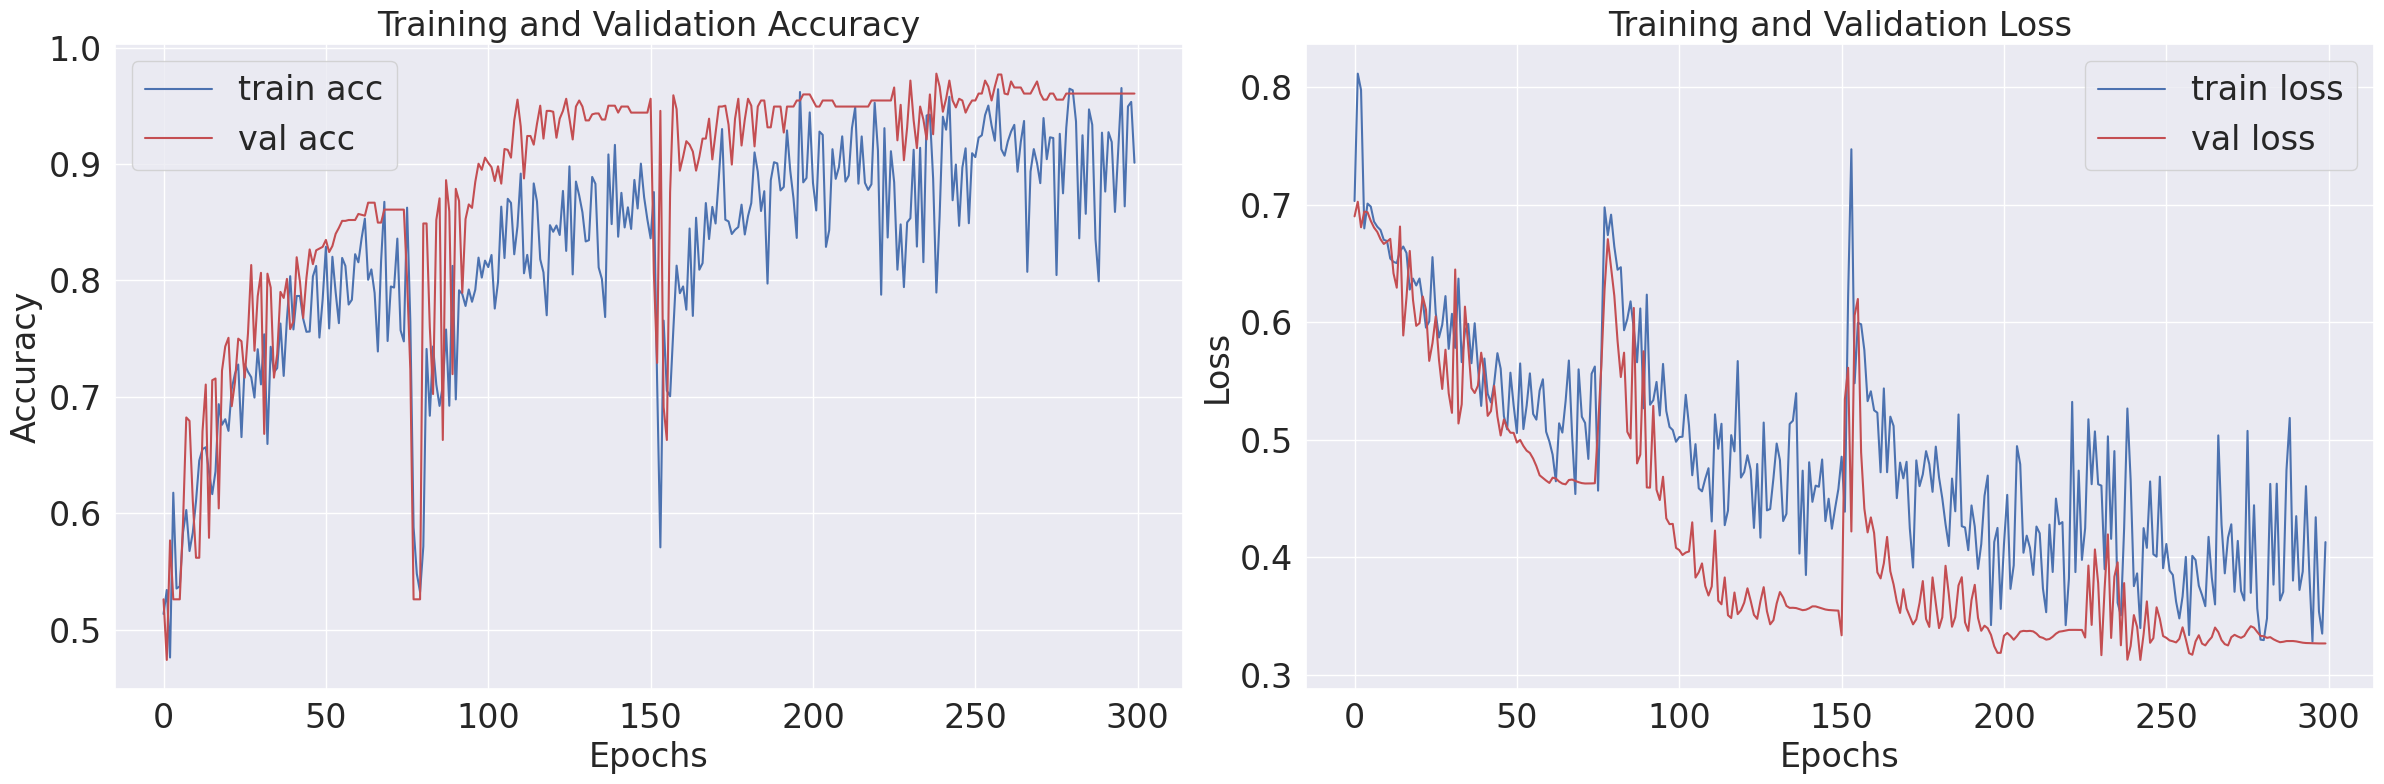

In [ ]:
#出力したテンソルのデバイスをCPUへ切り替える
# GoogleColabの場合は不要
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 仮にepochsの数をトレーニングデータの長さから取得する
epochs = len(train_acc_list)  # train_acc_listの長さを使用

train_acc = []
train_loss = []
val_acc = []
val_loss = []

# 各リストをnumpy配列に変換し、リストに追加
for i in range(epochs):
    train_acc.append(train_acc_list[i].detach().cpu().numpy())
    train_loss.append(train_loss_list[i].detach().cpu().numpy())
    val_acc.append(val_acc_list[i].detach().cpu().numpy())
    val_loss.append(val_loss_list[i].detach().cpu().numpy())

# グラフ化
sns.set()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))

ax1.plot(range(epochs), train_acc, 'b', label='train acc')
ax1.plot(range(epochs), val_acc, 'r', label='val acc')
ax1.set_title('Training and Validation Accuracy',fontsize=24)
ax1.set_xlabel('Epochs',fontsize=24)
ax1.set_ylabel('Accuracy',fontsize=24)
ax1.legend(fontsize=24)
ax1.tick_params(labelsize=24)

ax2.plot(range(epochs), train_loss, 'b', label='train loss')
ax2.plot(range(epochs), val_loss, 'r', label='val loss')
ax2.set_title('Training and Validation Loss',fontsize=24)
ax2.tick_params(labelsize=24)
ax2.set_xlabel('Epochs',fontsize=24)
ax2.set_ylabel('Loss',fontsize=24)
ax2.legend(fontsize=24)
ax2.tick_params(labelsize=24)
plt.tight_layout()
plt.show()


Extracting validation set logits...


Extracting logits: 100%|██████████| 3/3 [00:03<00:00,  1.12s/it]


Extracting test set logits...


Extracting logits: 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


Calibrating model...

Validation Set Results:


Calculating confidence interval: 100%|██████████| 1000/1000 [00:01<00:00, 656.92it/s]


Calibrated ROC AUC: 0.9775 [95% CI: 0.9436-0.9996]

Optimal Threshold Analysis (Validation Set):
Optimal threshold: 0.2161
Youden Index: 0.9441
Sensitivity: 0.9639
Specificity: 0.9802
Accuracy: 0.9728
F1-score: 0.9697

Test Set Results:


Calculating confidence interval: 100%|██████████| 1000/1000 [00:01<00:00, 690.19it/s]


Calibrated ROC AUC: 0.9970 [95% CI: 0.9887-1.0000]

Optimal Threshold Analysis (Test Set):
Using validation threshold: 0.2161
Sensitivity: 0.9714
Specificity: 0.9737
Accuracy: 0.9726
F1-score: 0.9714


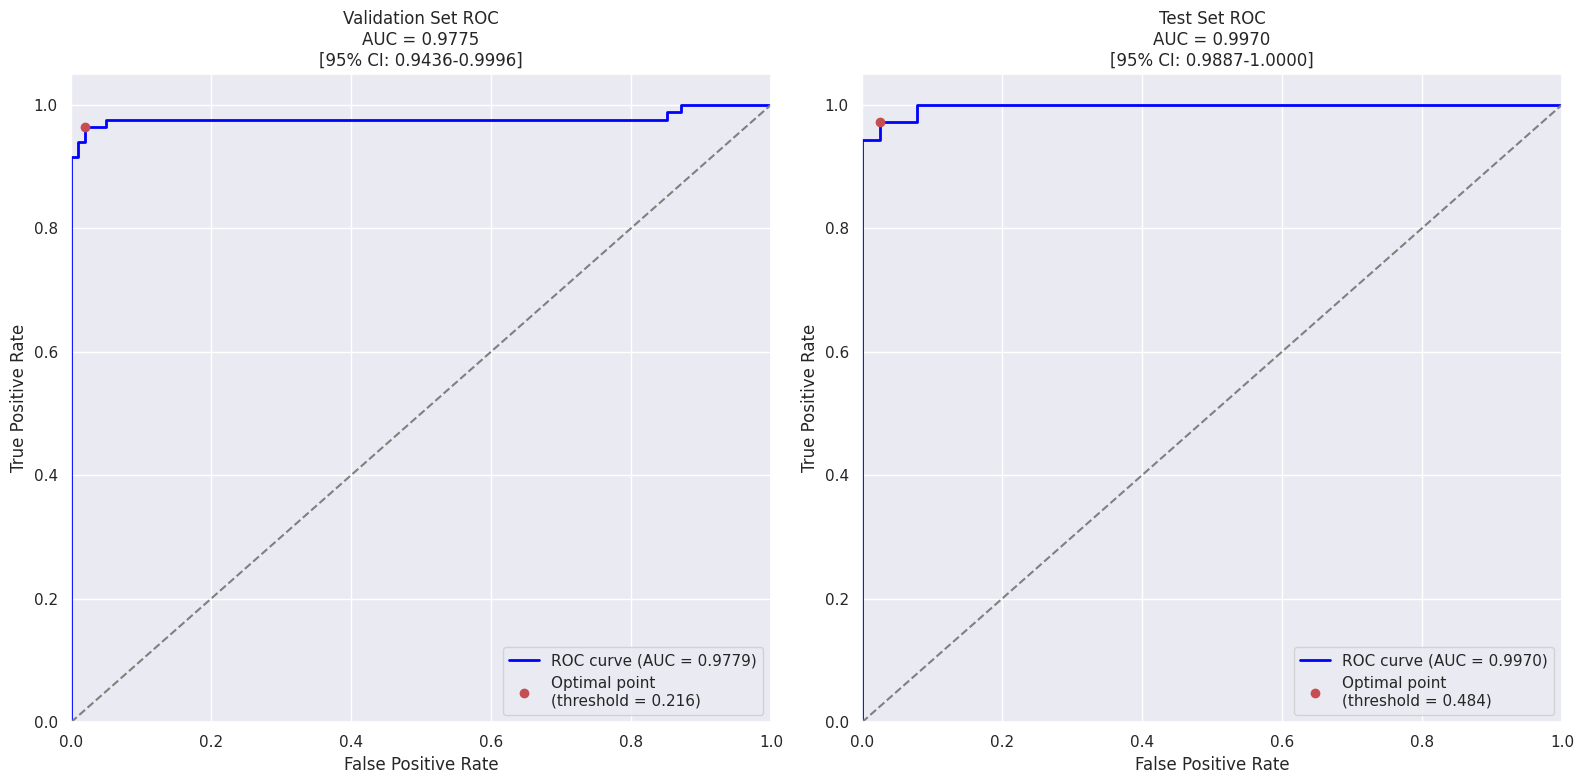

In [ ]:
import glob
import os
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from scipy import stats
from tqdm import tqdm
import seaborn as sns

def calculate_metrics(y_true, y_pred):
    """
    基本的な評価指標を計算
    """
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1_score
    }

def calculate_roc_auc_ci(y_true, y_pred, n_bootstraps=1000, confidence_level=0.95):
    """
    ROC-AUCスコアとその信頼区間を計算
    """
    bootstrapped_scores = []
    rng = np.random.RandomState(42)

    for i in tqdm(range(n_bootstraps), desc="Calculating confidence interval"):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)

    alpha = (1 - confidence_level)
    ci_lower = np.percentile(bootstrapped_scores, alpha/2 * 100)
    ci_upper = np.percentile(bootstrapped_scores, (1 - alpha/2) * 100)

    return np.mean(bootstrapped_scores), ci_lower, ci_upper

def calculate_optimal_threshold(y_true, y_pred_proba):
    """
    Youdenインデックスを用いて最適なカットオフ値を計算
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    youden_indices = tpr - fpr
    optimal_idx = np.argmax(youden_indices)
    optimal_threshold = thresholds[optimal_idx]

    y_pred = (y_pred_proba >= optimal_threshold).astype(int)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    youden_index = sensitivity + specificity - 1

    return {
        'threshold': optimal_threshold,
        'youden_index': youden_index,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'accuracy': accuracy,
        'precision': precision,
        'f1_score': f1_score,
        'confusion_matrix': {
            'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN
        }
    }

def plot_roc_curve_with_optimal_point(y_true, y_pred_proba, title, ax=None):
    """
    ROC曲線と最適カットオフ点をプロット
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    auc_score = auc(fpr, tpr)

    optimal_metrics = calculate_optimal_threshold(y_true, y_pred_proba)
    optimal_threshold = optimal_metrics['threshold']

    optimal_idx = np.argmin(np.abs(thresholds - optimal_threshold))
    optimal_fpr = fpr[optimal_idx]
    optimal_tpr = tpr[optimal_idx]

    # 既存のaxを使用するか、新しいfigureを作成
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    # プロット処理をax.plotに変更
    ax.plot(fpr, tpr, color='blue', lw=2,
            label=f'ROC curve (AUC = {auc_score:.4f})')
    ax.plot(optimal_fpr, optimal_tpr, 'ro',
            label=f'Optimal point\n(threshold = {optimal_threshold:.3f})')

    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(True)

    return optimal_metrics

def extract_logits(model, loader, device):
    """
    モデルからロジットを抽出
    """
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for data, target in tqdm(loader, desc="Extracting logits"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return np.array(logits), np.array(targets)

def calibrate_and_evaluate(model, valid_loader, test_loader, device):
    """
    モデルのキャリブレーションと評価を実行
    """
    print("Extracting validation set logits...")
    val_logits, val_targets = extract_logits(model, valid_loader, device)

    print("Extracting test set logits...")
    test_logits, test_targets = extract_logits(model, test_loader, device)

    # プラットスケーリングの設定と実行
    print("Calibrating model...")
    calibrator = LogisticRegression(solver='liblinear', max_iter=1000)
    calibrated_model = CalibratedClassifierCV(calibrator, method='sigmoid', cv='prefit')

    calibrator.fit(val_logits, val_targets)
    calibrated_model.fit(val_logits, val_targets)

    # 予測確率の取得
    val_probs = calibrated_model.predict_proba(val_logits)[:, 1]
    test_probs = calibrated_model.predict_proba(test_logits)[:, 1]

    # 検証セットの評価
    print("\nValidation Set Results:")
    val_auc, val_ci_lower, val_ci_upper = calculate_roc_auc_ci(val_targets, val_probs)
    print(f"Calibrated ROC AUC: {val_auc:.4f} [95% CI: {val_ci_lower:.4f}-{val_ci_upper:.4f}]")

    # 検証セットの最適カットオフ値を計算
    val_optimal_metrics = calculate_optimal_threshold(val_targets, val_probs)
    print("\nOptimal Threshold Analysis (Validation Set):")
    print(f"Optimal threshold: {val_optimal_metrics['threshold']:.4f}")
    print(f"Youden Index: {val_optimal_metrics['youden_index']:.4f}")
    print(f"Sensitivity: {val_optimal_metrics['sensitivity']:.4f}")
    print(f"Specificity: {val_optimal_metrics['specificity']:.4f}")
    print(f"Accuracy: {val_optimal_metrics['accuracy']:.4f}")
    print(f"F1-score: {val_optimal_metrics['f1_score']:.4f}")

    # テストセットの評価
    print("\nTest Set Results:")
    test_auc, test_ci_lower, test_ci_upper = calculate_roc_auc_ci(test_targets, test_probs)
    print(f"Calibrated ROC AUC: {test_auc:.4f} [95% CI: {test_ci_lower:.4f}-{test_ci_upper:.4f}]")

    # 検証セットで得られた最適カットオフ値をテストセットに適用
    test_metrics = calculate_optimal_threshold(test_targets, test_probs)
    print("\nOptimal Threshold Analysis (Test Set):")
    print(f"Using validation threshold: {val_optimal_metrics['threshold']:.4f}")
    print(f"Sensitivity: {test_metrics['sensitivity']:.4f}")
    print(f"Specificity: {test_metrics['specificity']:.4f}")
    print(f"Accuracy: {test_metrics['accuracy']:.4f}")
    print(f"F1-score: {test_metrics['f1_score']:.4f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    val_optimal_metrics = plot_roc_curve_with_optimal_point(
        val_targets, val_probs,
        f"Validation Set ROC\nAUC = {val_auc:.4f}\n[95% CI: {val_ci_lower:.4f}-{val_ci_upper:.4f}]",
        ax=ax1
    )

    test_optimal_metrics = plot_roc_curve_with_optimal_point(
        test_targets, test_probs,
        f"Test Set ROC\nAUC = {test_auc:.4f}\n[95% CI: {test_ci_lower:.4f}-{test_ci_upper:.4f}]",
        ax=ax2
    )

    plt.tight_layout()
    plt.show()

    # モデルを更新
    model.calibrator = calibrated_model

    return {
        'validation': {
            'auc': val_auc,
            'ci_lower': val_ci_lower,
            'ci_upper': val_ci_upper,
            'optimal_metrics': val_optimal_metrics,
            'predictions': val_probs
        },
        'test': {
            'auc': test_auc,
            'ci_lower': test_ci_lower,
            'ci_upper': test_ci_upper,
            'optimal_metrics': test_optimal_metrics,
            'predictions': test_probs
        }
    }

# メインの実行部分
if __name__ == "__main__":
    # モデルのトレーニング後に実行
    results = calibrate_and_evaluate(model, valid_loader, test_loader, device)

In [ ]:
model_save_path = '/content/drive/MyDrive/swin_transformer_with_mixup_checkpoint4'
torch.save(model.state_dict(), model_save_path)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV

def extract_logits(model, loader, device):
    model.eval()
    logits = []
    targets = []
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            logits.extend(output.cpu().numpy())
            targets.extend(target.cpu().numpy())
    return np.array(logits), np.array(targets)

# ロジットとターゲットを抽出
val_logits, val_targets = extract_logits(model, valid_loader, device)

# プラットスケーリングを使用してモデルをカリブレーション
calibrator = LogisticRegression(solver='liblinear', max_iter=1000)
calibrated_model = CalibratedClassifierCV(calibrator, method='sigmoid', cv='prefit')

# 検証セットのロジットとターゲットを使って、ベースのcalibratorをフィッティング
calibrator.fit(val_logits, val_targets)
# 検証セットの確率を使ってフィッティング
calibrated_model.fit(val_logits, val_targets)

# カリブレーション後の確率を評価
calibrated_probs = calibrated_model.predict_proba(val_logits)[:, 1]

# パフォーマンス評価
roc_auc = roc_auc_score(val_targets, calibrated_probs)
print(f"Calibrated ROC AUC: {roc_auc:.4f}")

# 保存や他の用途で使用するためにモデルを更新
model.calibrator = calibrated_model

Calibrated ROC AUC: 0.9779


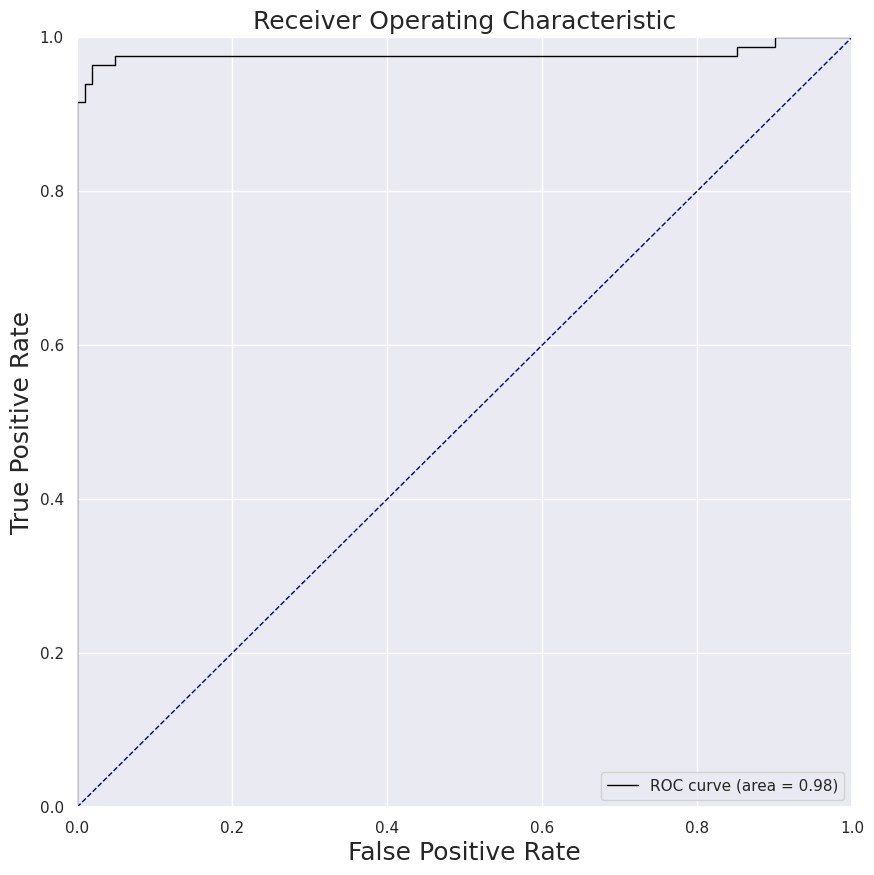

In [ ]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(model, loader, device):
    # 真のラベルと予測確率を収集
    true_labels = []
    pred_probs = []

    model.eval()
    with torch.no_grad():
        for data, labels in loader:
            data = data.to(device)
            labels = labels.to(device)
            outputs = model(data)
            # ソフトマックスを適用して確率を取得
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            pred_probs.extend(probabilities[:, 1].cpu().numpy())  # クラス1の確率を取得
            true_labels.extend(labels.cpu().numpy())

    # ROCカーブの計算
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)

    # ROCカーブの描画
    plt.figure(figsize=(10, 10))
    lw = 1
    plt.plot(fpr, tpr, color='black',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 2], [0, 2], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate',fontsize=18)
    plt.ylabel('True Positive Rate',fontsize=18)
    plt.title('Receiver Operating Characteristic',fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# 使用例: 有効データローダーとデバイス情報を指定してROC曲線を描画
plot_roc_curve(model, valid_loader, device)


In [ ]:
import pickle
# カリブレーターの保存
with open('/content/drive/MyDrive/calibrated_model4.pkl', 'wb') as f:
    pickle.dump(calibrated_model, f)

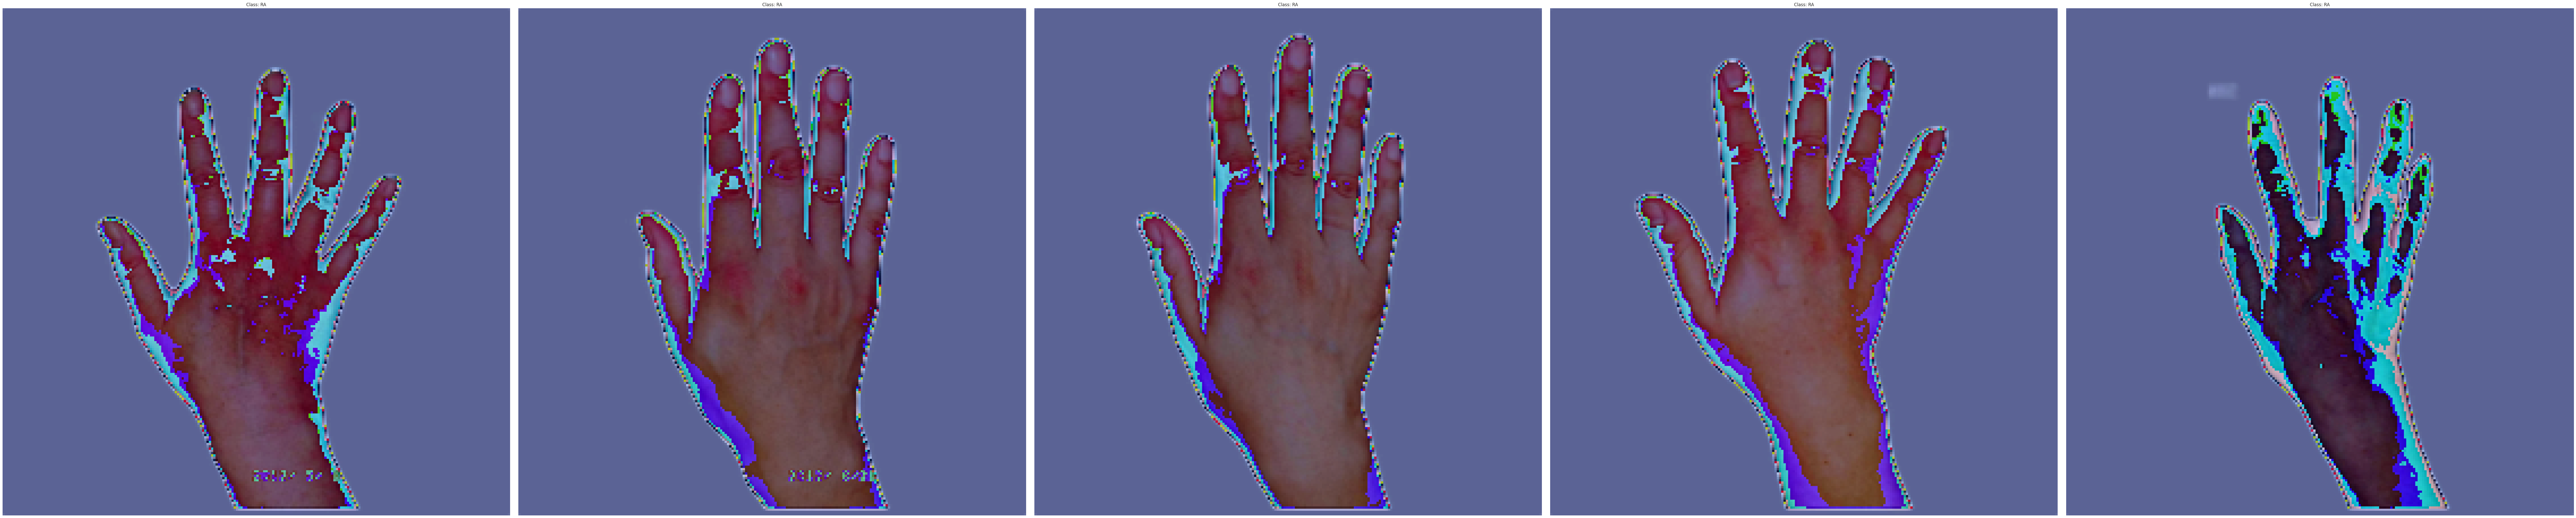

32407

In [ ]:
class GradCam:
    def __init__(self, model, device):
        self.model = model
        self.feature = None
        self.gradient = None
        self.device = device

        def forward_hook(module, input, output):
            self.feature = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradient = grad_out[0].detach()

        # Swin Transformerの最後のブロックを取得
        if hasattr(model, 'layers'):
            target_layer = model.layers[-1].blocks[-1]
            target_layer.register_forward_hook(forward_hook)
            target_layer.register_full_backward_hook(backward_hook)
        else:
            raise ValueError("Unexpected model architecture")

    def __call__(self, x):
        self.feature = None
        self.gradient = None

        x = x.to(self.device)

        output = self.model(x)
        pred_class = output.argmax(dim=1)

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, pred_class] = 1
        output.backward(gradient=one_hot)

        # Swin Transformerの特徴量マップの形状に合わせて処理
        feature_map = self.feature
        gradient_map = self.gradient

        # 重みの計算
        weights = gradient_map.mean(dim=(2, 3))  # Swinの場合、spatial dimensionsで平均を取る

        # CAMの計算
        batch_size = feature_map.shape[0]
        height = feature_map.shape[2]
        width = feature_map.shape[3]

        cam = torch.mul(feature_map, weights.view(batch_size, -1, 1, 1))
        cam = cam.sum(dim=1)  # チャネル方向に集約

        # 正規化とReLU
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        # 元の画像サイズにリサイズ
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-7)

        return cam

def overlay_heatmap_to_image(image, heatmap):
    image = ((image.permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5) * 255).astype(np.uint8)

    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    alpha = 0.2
    overlayed = cv2.addWeighted(image, 1 - alpha, heatmap_colored, alpha, 0)

    return overlayed / 255.0

# 実行部分
grad_cam = GradCam(model, device)

images, labels = next(iter(test_loader))
images = images[:5]
labels = labels[:5]

plt.figure(figsize=(100, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    try:
        heatmap = grad_cam(image.unsqueeze(0))
        overlayed = overlay_heatmap_to_image(image, heatmap)

        plt.subplot(1, 5, i+1)
        plt.imshow(overlayed)
        plt.title(f'Class: {"RA" if label.item() == 0 else "Non-RA"}')
        plt.axis('off')
    except Exception as e:
        print(f"Error processing image {i}: {str(e)}")

plt.tight_layout()
plt.show()

torch.cuda.empty_cache()
gc.collect()

<ipython-input-28-3c2aafc37d31>:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/swin_transformer_with_mixup_check

Overall Accuracy: 0.772


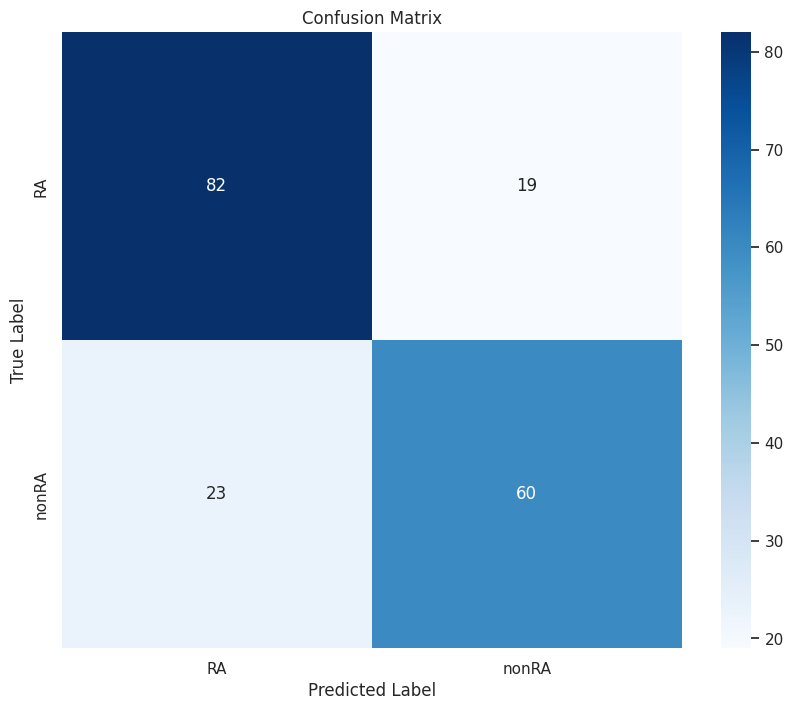

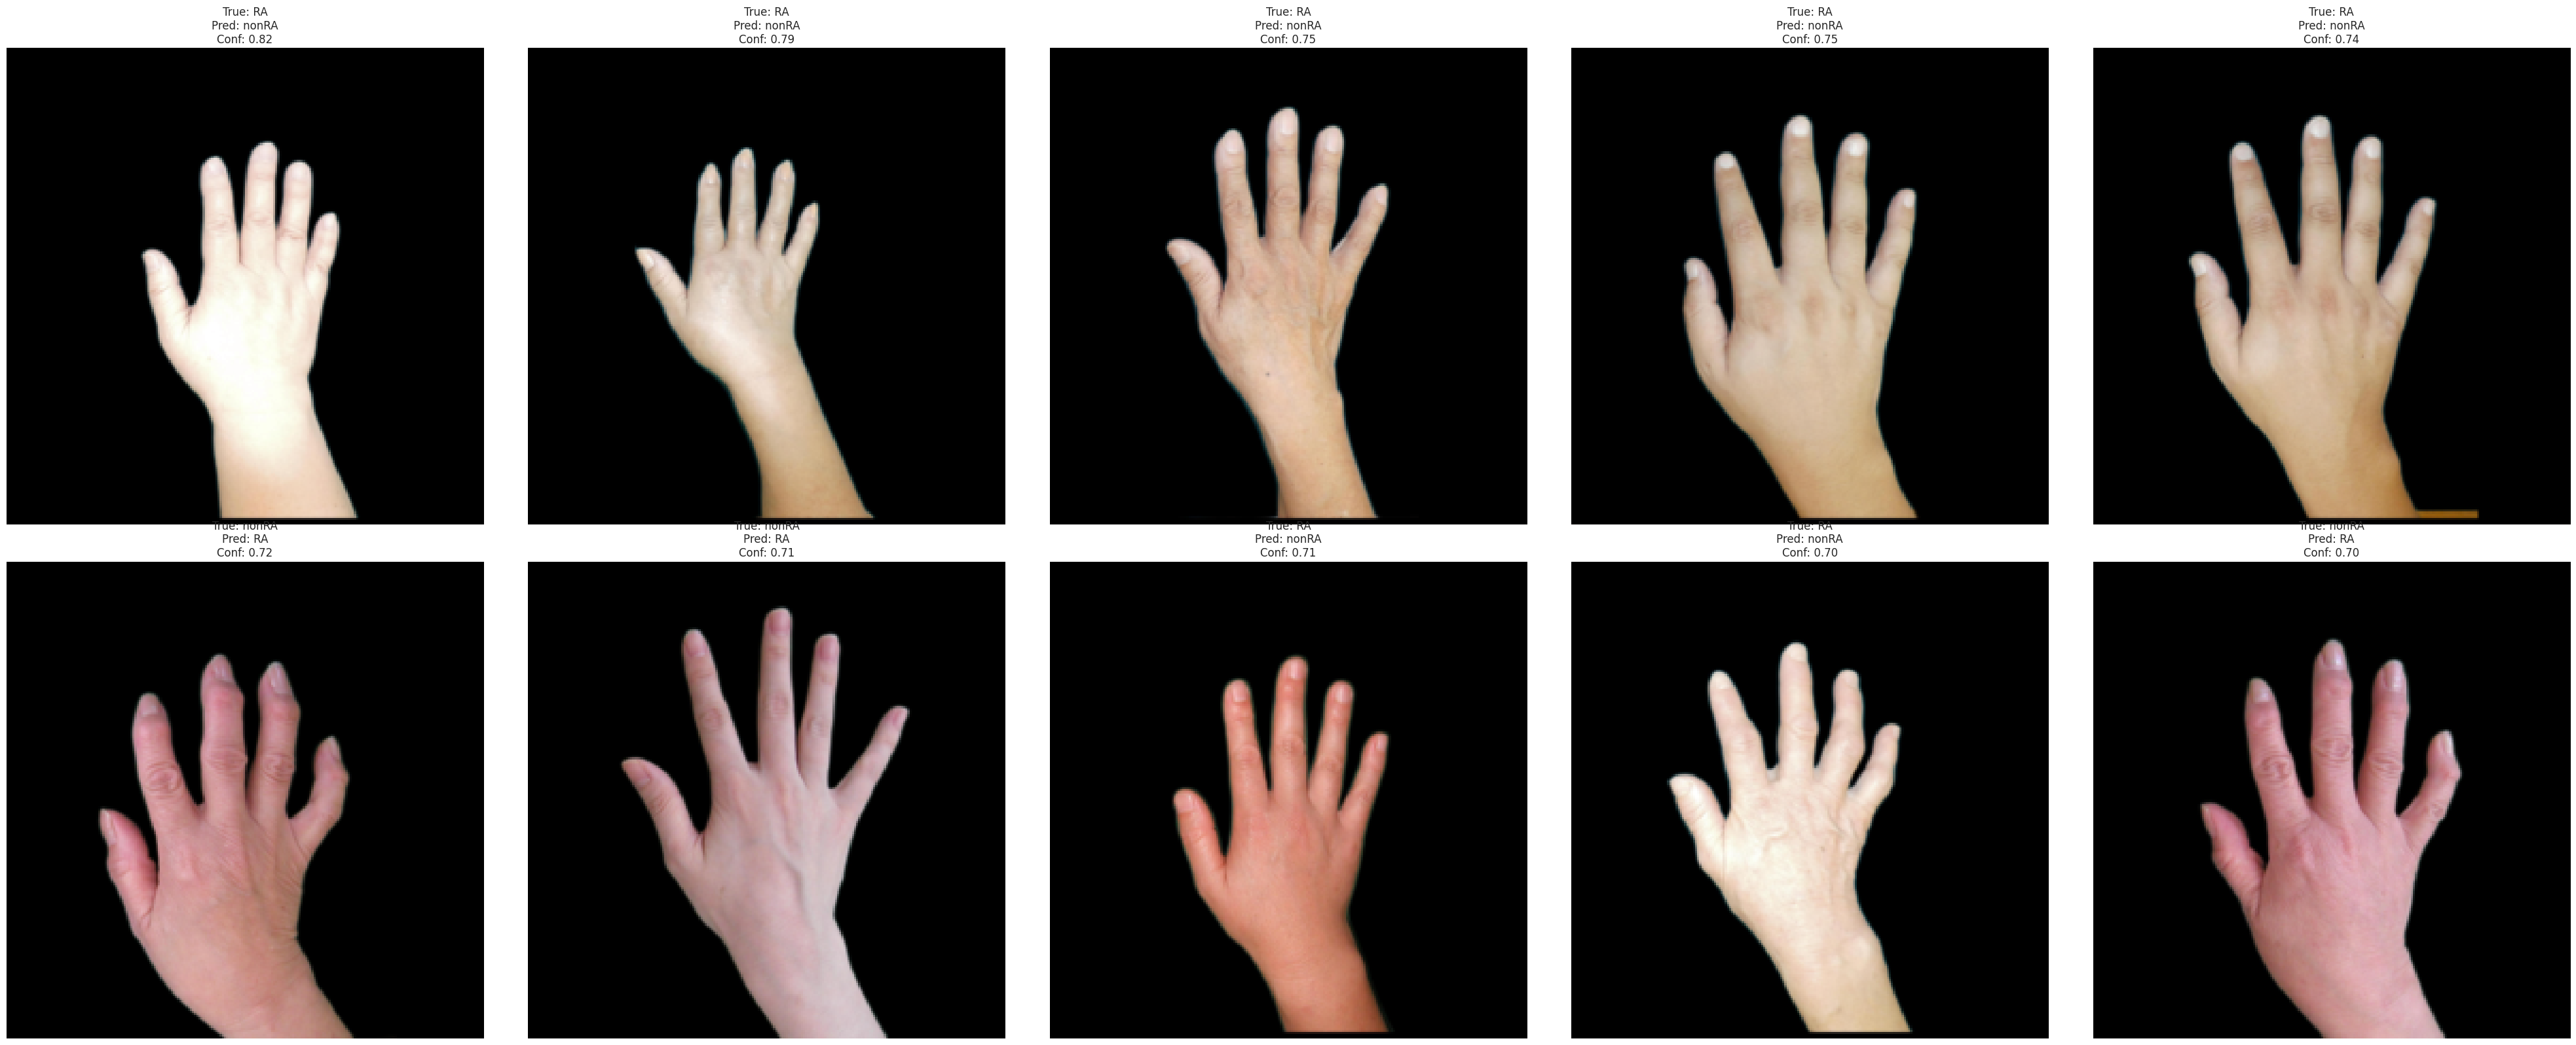

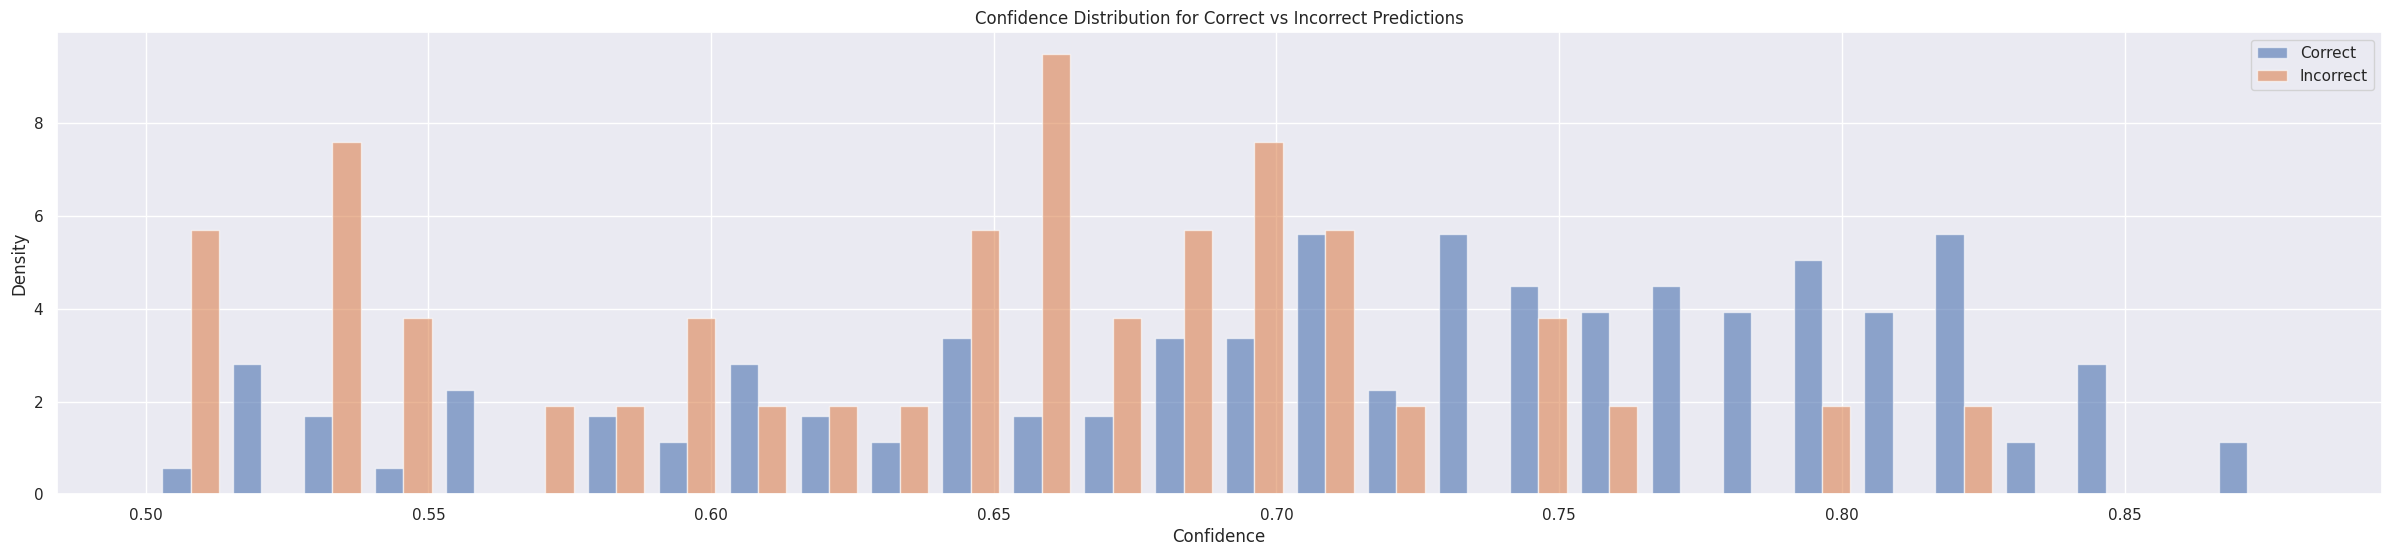


Class RA:
Accuracy: 0.812
Average confidence: 0.715
Samples: 101

Class nonRA:
Accuracy: 0.723
Average confidence: 0.680
Samples: 83


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.utils import make_grid
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def get_predictions(model, val_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    confidences = []
    images_list = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            conf, preds = torch.max(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            confidences.extend(conf.cpu().numpy())
            images_list.extend(images.cpu())

    return np.array(predictions), np.array(true_labels), np.array(confidences), images_list

def plot_confusion_matrix(true_labels, predictions, class_names):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names):
    misclassified_idx = np.where(predictions != true_labels)[0]

    if len(misclassified_idx) == 0:
        print("No misclassified samples found!")
        return

    sorted_idx = sorted(misclassified_idx,
                       key=lambda x: confidences[x],
                       reverse=True)

    n_samples = min(10, len(sorted_idx))
    fig, axes = plt.subplots(2, 5, figsize=(40, 16))
    axes = axes.ravel()

    for idx, ax in enumerate(axes):
        if idx < n_samples:
            mis_idx = sorted_idx[idx]
            image = images_list[mis_idx]
            true_label = class_names[true_labels[mis_idx]]
            pred_label = class_names[predictions[mis_idx]]
            conf = confidences[mis_idx]

            # 画像の正規化を元に戻す（必要に応じて調整）
            image = image.permute(1, 2, 0)
            image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            image = torch.clamp(image, 0, 1)

            ax.imshow(image)
            ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.2f}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()

def plot_confidence_distribution(confidences, predictions, true_labels):
    plt.figure(figsize=(30, 6))

    correct = confidences[predictions == true_labels]
    incorrect = confidences[predictions != true_labels]

    plt.hist([correct, incorrect], label=['Correct', 'Incorrect'],
             bins=30, alpha=0.6, density=True)
    plt.xlabel('Confidence')
    plt.ylabel('Density')
    plt.title('Confidence Distribution for Correct vs Incorrect Predictions')
    plt.legend()
    plt.show()

# メインの実行コード
def main():
    # デバイスの設定
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # クラス名の設定（あなたのデータセットに合わせて修正）
    class_names = ['RA', 'nonRA']  # あなたのクラス名に置き換えてください

    model = timm.create_model(
        'swin_base_patch4_window7_224.ms_in1k',
        pretrained=False,
        num_classes=2,
    )

    # モデルの読み込み（あなたの保存したモデルのパスに修正）
    model.load_state_dict(torch.load('/content/drive/MyDrive/swin_transformer_with_mixup_checkpoint3'))
    model = model.to(device)

    # 予測の実行
    predictions, true_labels, confidences, images_list = get_predictions(model, val_loader, device)

    # 全体の性能メトリクス
    accuracy = np.mean(predictions == true_labels)
    print(f"Overall Accuracy: {accuracy:.3f}")

    # 混同行列の表示
    plot_confusion_matrix(true_labels, predictions, class_names)

    # 誤分類サンプルの表示
    analyze_misclassifications(true_labels, predictions, confidences, images_list, class_names)

    # 確信度分布の表示
    plot_confidence_distribution(confidences, predictions, true_labels)

    # クラスごとの詳細な分析
    for i, class_name in enumerate(class_names):
        class_mask = true_labels == i
        class_acc = np.mean(predictions[class_mask] == true_labels[class_mask])
        print(f"\nClass {class_name}:")
        print(f"Accuracy: {class_acc:.3f}")
        print(f"Average confidence: {np.mean(confidences[class_mask]):.3f}")
        print(f"Samples: {np.sum(class_mask)}")

if __name__ == '__main__':
    val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)  # あなたの検証用DataLoaderを設定

    main()